<h1 align="center"><b>Data Science Brigade - Teste Técnico</h1>

<h3 align="center">Bruno Di Franco Albuquerque</b></h3>


# 1. **Imports**

## 1.1. **Bibliotecas**

In [1]:
import pickle
import locale
import warnings
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections   import Counter
from nltk.corpus   import stopwords
from names_dataset import NameDataset
from gensim.utils  import simple_preprocess
from gensim.models import CoherenceModel, Phrases, phrases, ldamulticore
import gensim.corpora as corpora

# Settings
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Funções auxiliares

def data_shape(df):
    '''
    Número de colunas e linhas para um Dataframe.

    Parameters
    ----------
    df : Dataframe no qual a função será aplicada.
    
    Returns
    -------
    None 
    '''   
    print(f'Número de Linhas: {df.shape[0]}')
    print(f'Número de Colunas: {df.shape[1]}')

    return None 

def tokenizar(textos):
    '''
    Tokeniza o texto com gensim.utils.simple_preprocess

    Parameters
    ----------
    textos : textos.
    
    Returns
    -------
    None 
    '''   
    for texto in textos:
        yield(simple_preprocess(str(texto), deacc=True))
    return None
            
def aplicar_bigrams(bigram_model, textos):
    '''
    Aplica bigram.

    Parameters
    ----------
    bigram_model : modelo de bigram

    textos : textos.
    
    Returns
    -------
    bigram_model nos textos 
    '''   
    return [bigram_model[doc] for doc in textos]

def aplicar_trigrams(bigram_model, trigram_model, textos):
    '''
    Aplica trigram.

    Parameters
    ----------
    bigram_model : modelo de bigram

    trigram_model : modelo de trigram

    textos : textos.
    
    Returns
    -------
    trigram_model nos textos  
    '''  
    return [trigram_model[bigram_model[doc]] for doc in textos]

warnings.filterwarnings("ignore", category=DeprecationWarning) # A mensagem de Deprecation é por causa da própria classe WordCloud, por isso a remoção do aviso.
def word_cloud(stopwords, modelo, n_topicos, figsize=(20,20)):
    '''
    Display de word cloud.

    Parameters
    ----------
    stopwords : stopwords

    modelo : modelo usado

    n_topicos : número de tópicos

    Returns
    -------
    ax : word_clud 
    '''   
    cloud = WordCloud(stopwords=stopwords,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=7,
                    colormap='tab10',
                    prefer_horizontal=1.0)
    topics = modelo.show_topics(formatted=False)
    fig, axes = plt.subplots(1, n_topicos, figsize=figsize, sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=400)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()    
    return ax    

def bar_plot_values_on_top(x, y, aux, rotate=None, figsize=(10,5)):
    '''
    Bar plot com os valores mostrados em cima da barra.

    Parameters
    ----------
    aux : dataframe auxiliar.

    x : valores de x

    y : valores de y

    Returns
    -------
    ax : bar plots.
    '''   
    if rotate:
        plt.figure(figsize=figsize)
        ax = sns.barplot(x=x, y=y, data=aux, palette='deep')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")

        for i in ax.containers:    
            ax.bar_label(i,)

        return ax

    else:
        plt.figure(figsize=figsize)
        ax = sns.barplot(x=x, y=y, data=aux, palette='deep')

        for i in ax.containers:    
            ax.bar_label(i,)

        return ax

def func(pct, valores):
    '''
    Percentual de valores. 
    Usada no pie_chart
    '''
    real = int(pct / 100.*np.sum(valores))
    return "{:,.2f}%\n {}".format(pct, locale.currency(real, grouping=True))
                
def pie_chart(aux, y, titulo, labels, size=8, figsize=(18, 10)):
    '''
    Gráfico de pizza.

    Parameters
    ----------
    aux : dataframe auxiliar.

    y : valores de y

    titulo : título do gráfico

    labels : labels

    Returns
    -------
    ax : pie charts.
    ''' 
    # Parâmetros
    explode = []
    explode.extend([0.05 for i in range(len(aux))])
    explode = tuple(explode)
    wp = {'linewidth' : 0.7, 'edgecolor' : "black"}
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    wedges, texts, autotexts = ax.pie(aux[y],
                                    autopct = lambda pct: func(pct, aux[y]),
                                    explode = explode,
                                    labels = labels,
                                    shadow = True,
                                    startangle = 90,
                                    wedgeprops = wp,
                                    textprops = dict(color ="black"))

    ax.set_title(titulo)
    plt.setp(autotexts, fontsize = size, weight ="bold")

    return ax

## 1.2. **Carregar os dados e unir as tabelas**

In [3]:
# Licitações
lic_2016 = pd.read_csv('data/2016/licitacao.csv', low_memory=False)
lic_2017 = pd.read_csv('data/2017/licitacao.csv', low_memory=False)
lic_2018 = pd.read_csv('data/2018/licitacao.csv', low_memory=False)
lic_2019 = pd.read_csv('data/2019/licitacao.csv', low_memory=False)

# Itens
item_2016 = pd.read_csv('data/2016/item.csv', low_memory=False)
item_2017 = pd.read_csv('data/2017/item.csv', low_memory=False)
item_2018 = pd.read_csv('data/2018/item.csv', low_memory=False)
item_2019 = pd.read_csv('data/2019/item.csv', low_memory=False)

- As tabelas de licitações 2016, 2017, 2018 e 2019 são exatamente iguais em termos de colunas, logo serão unidas para a análise. O mesmo vale para a tabela de itens.

In [4]:
# Concatenando
df_lic = pd.concat([lic_2016, lic_2017, lic_2018, lic_2019], axis=0)
df_itens = pd.concat([item_2016, item_2017, item_2018, item_2019], axis=0)

# Convertendo pra lowercase as colunas (preferência pessoal)
df_lic.columns = map(str.lower, df_lic.columns)
df_itens.columns = map(str.lower, df_itens.columns)

Como são muitas colunas, a descrição das tabelas está disponível <a href="https://github.com/brunodifranco/ds-brigade-teste-tecnico-bruno-di-franco/tree/main/tabelas_definicoes">aqui</a>, para facilitar o entendimento.

In [5]:
df_lic.sample(5)

,cd_orgao,nm_orgao,nr_licitacao,ano_licitacao,cd_tipo_modalidade,nr_comissao,ano_comissao,tp_comissao,nr_processo,ano_processo,...,tp_documento_fornecedor,nr_documento_fornecedor,tp_documento_vencedor,nr_documento_vencedor,vl_homologado,bl_gera_despesa,ds_observacao,pc_tx_estimada,pc_tx_homologada,bl_compartilhada
2417,41500,PM DE AUGUSTO PESTANA,5.00,2018,CNV,52.00,2018.00,P,247,2018.00,...,NaN,NaN,J,15804991000132,12050.00,S,NaN,NaN,NaN,N
70530,78300,PM DE NOVO BARREIRO,7.00,2019,PRD,NaN,NaN,NaN,017,2019.00,...,J,32111141000178.00,NaN,NaN,NaN,S,NaN,NaN,NaN,N
22519,58600,PM DE SÃO JOSÉ DO OURO,5.00,2016,PRD,1.00,2016.00,P,005,2016.00,...,J,8950047000128.00,NaN,NaN,NaN,S,NaN,NaN,NaN,N
21622,47800,PM DE FARROUPILHA,70.00,2017,PRP,442.00,2017.00,G,2867,2017.00,...,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,N
13280,43900,PM DE CAMPO BOM,157.00,2018,PRD,NaN,NaN,NaN,37323,2018.00,...,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,N


In [6]:
data_shape(df_lic)

Número de Linhas: 237011
Número de Colunas: 61


In [7]:
df_itens.sample(5)

,cd_orgao,nr_licitacao,ano_licitacao,cd_tipo_modalidade,nr_lote,nr_item,nr_item_original,ds_item,qt_itens,sg_unidade_medida,...,tp_orcamento,cd_tipo_familia,cd_tipo_subfamilia,tp_documento,nr_documento,tp_documento.1,nr_documento.1,tp_beneficio_micro_epp,pc_tx_estimada,pc_tx_homologada
427136,68500,9.00,2019,TMP,9,34,9.8,PAPELEIRA DE PAREDE EM METAL CROMADO SEM TAMPA...,6.00,UN,...,NaN,NaN,NaN,J,14400830000110,NaN,NaN,NaN,NaN,NaN
68661,69000,3.00,2016,PRP,1,169,169M,NATIFA PRO,500.00,UN,...,NaN,NaN,NaN,J,15068089000103.00,NaN,NaN,T,NaN,NaN
380338,46900,111.00,2018,PRP,1,123,123,Tubo PEAD PN 10 compressão 20mm,100.00,M,...,NaN,NaN,NaN,J,13745092000180,NaN,NaN,N,NaN,NaN
185848,68100,6.00,2017,CNC,1,71,71,CARTOLINA 150G 50X66 BRANCO CARD SET VCP,100.00,UN,...,NaN,NaN,NaN,J,03696188000142,NaN,NaN,T,NaN,NaN
192251,88377,1.00,2018,PRE,1,1132,1133,salmeterol (xinafoato) 25mcg + fluticasona (pr...,330.00,COM,...,NaN,880.00,NaN,J,08328835000187,NaN,NaN,T,NaN,NaN


In [8]:
data_shape(df_itens)

Número de Linhas: 3200756
Número de Colunas: 32


#### 1.3. **Carregar os dados e unir as tabelas**

<p align="justify">As duas tabelas representam o mesmo fenômeno, de forma que df_lic tem a descrição geral do item, por exemplo, 'aquisição de merenda escolar', enquanto df_itens tem a descrição detalhada de cada item, como 'bolacha maria, iogurte e leite', por exemplo. Portanto, é possível selecionar somente um para fazer a análise, sendo no caso <b>df_lic</b> o selecionado, pois: </p>

- <p align="justify"> Somente com a descrição geral de cada licitação já será possível <b>fazer uma boa exploração dos dados</b>, pois, conforme já mencionado, as duas tabelas representam o mesmo fenômeno.</p>
- <p align="justify"> O df_lic tem um tamanho muito menor que df_itens, o que é mais leve para rodar o código, dado o tempo do projeto. Um exemplo disso é o modelo utilizado (LDA - Latent Dirichlet Allocation) que leva em torno de 3 minutos para rodar no df_lic e 7 horas para rodar no df_itens.</p>

<p align="justify"><i>Ainda sobre o modelo LDA, quando aplicado no df_itens este não consegue captar a questão das licitações voltadas a escolas/educação, o que é uma parte muito importante na análise do orçamento público.</i></p>

<p align="justify"><i>Apesar do df_itens não ser usado diretamente na análise, ele será usado para concatenar informações faltantes na tabela df_lic.</i></p>

# 2. **Data Cleaning**

## 2.1. **df_itens**

#### 2.1.1. **Removendo colunas desnecessárias**

<p align="justify">Apesar do df_itens não ser usado diretamente na análise, ele será usado para recuperar os NaN's presentes no <i>vl_homologado</i> do df_lic. Por isso só as seguintes colunas serão mantidas:</p> 

- cd_orgao
- nr_licitacao
- ano_licitacao
- cd_tipo_modalidade
- vl_total_homologado

In [9]:
itens_drop = ['nr_lote', 'nr_item', 'nr_item_original', 'ds_item', 'qt_itens',
              'sg_unidade_medida', 'vl_unitario_estimado', 'vl_total_estimado',
              'dt_ref_valor_estimado', 'pc_bdi_estimado', 'pc_encargos_sociais_estimado',
              'cd_fonte_referencia', 'ds_fonte_referencia', 'tp_resultado_item',
              'vl_unitario_homologado', 'pc_bdi_homologado','pc_encargos_sociais_homologado',
              'tp_orcamento', 'cd_tipo_familia', 'cd_tipo_subfamilia', 'tp_documento',
              'nr_documento', 'tp_documento.1', 'nr_documento.1', 'tp_beneficio_micro_epp',
              'pc_tx_estimada', 'pc_tx_homologada']

df_itens = df_itens.drop(itens_drop, axis=1)

## 2.2. **df_lic**

<p align="justify">Serão selecionadas somente as licitações do tipo "COMPRA":</p>

In [10]:
df_lic = df_lic[df_lic['tp_objeto']=='COM']
data_shape(df_lic)

Número de Linhas: 82405
Número de Colunas: 61


2.2.1. **Removendo colunas desnecessárias**

In [11]:
df_lic.isna().sum()

cd_orgao                  0
nm_orgao                  0
nr_licitacao              0
ano_licitacao             0
cd_tipo_modalidade        0
                      ...  
bl_gera_despesa           0
ds_observacao         79431
pc_tx_estimada        82404
pc_tx_homologada      82405
bl_compartilhada          0
Length: 61, dtype: int64

<p align="justify"> A maioria das colunas de df_lic não serão usadas na análise, pois a maior parte dos valores dessas colunas são NaN's e/ou contém pouca informação útil para a análise.</p>

<hp align="justify"> Sobre colunas "parecidas", o porquê de algumas colunas serem mantidas e outras não:

- <b>dt_abertura</b> x <b>dt_homologacao</b>: dt_homologacao será mantida, pois é a data mais próxima do uso do recurso, porém como 1/4 dela é composta por NaN's ela precisará ser tratada. 
- <b>vl_licitacao</b> x <b>vl_homologado</b>: vl_homologado será mantido, pois é o real valor disponibilizado na licitação.</p>

In [12]:
# removendo as colunas que não serão usadas
lic_drop = ['nr_comissao', 'ano_comissao', 'tp_comissao',
            'nr_processo', 'ano_processo', 'cd_tipo_fase_atual',
            'tp_licitacao', 'tp_nivel_julgamento', 'dt_autorizacao_adesao',
            'tp_caracteristica_objeto', 'tp_natureza', 'tp_regime_execucao',
            'bl_permite_subcontratacao', 'tp_beneficio_micro_epp',
            'tp_fornecimento', 'tp_atuacao_registro', 'nr_licitacao_original',
            'ano_licitacao_original', 'nr_ata_registro_preco',
            'dt_ata_registro_preco', 'pc_taxa_risco', 'tp_execucao', 'tp_disputa',
            'tp_prequalificacao', 'bl_inversao_fases', 'tp_resultado_global',
            'cnpj_orgao_gerenciador', 'nm_orgao_gerenciador', 
            'cd_tipo_fundamentacao', 'nr_artigo', 'ds_inciso', 'ds_lei',
            'dt_inicio_inscr_cred', 'dt_fim_inscr_cred', 'dt_inicio_vigen_cred',
            'dt_fim_vigen_cred', 'vl_licitacao', 'bl_orcamento_sigiloso',
            'bl_recebe_inscricao_per_vig', 'bl_permite_consorcio', 
            'dt_adjudicacao', 'bl_licit_propria_orgao',
            'tp_documento_fornecedor', 'nr_documento_fornecedor',
            'tp_documento_vencedor', 'nr_documento_vencedor', 
            'bl_gera_despesa', 'ds_observacao', 'pc_tx_estimada',
            'pc_tx_homologada', 'bl_compartilhada'] 

df_lic = df_lic.drop(lic_drop, axis=1)
df_lic.columns

Index(['cd_orgao', 'nm_orgao', 'nr_licitacao', 'ano_licitacao',
       'cd_tipo_modalidade', 'tp_objeto', 'ds_objeto', 'dt_abertura',
       'dt_homologacao', 'vl_homologado'],
      dtype='object')

2.2.2. **Tratando NaN's em dt_homologacao**

<p align="justify"> Uma forma de recuperar os valores nulos na data de homologação é substituí-los pela data de abertura do processo, já que, dentro das possibilidades, a melhor aproximação para a data de homologação é a data de abertura do processo. </p>

In [13]:
df_lic['dt_homologacao'] = df_lic['dt_homologacao'].fillna(df_lic['dt_abertura'])
df_lic['dt_homologacao'] = pd.to_datetime(df_lic['dt_homologacao']) # converter para dt

df_lic = df_lic.drop(columns=['tp_objeto', 'dt_abertura']) # tp_objeto não é mais necessário, pois somente o que é compra já está selecionado

2.2.3. **Tratando NaN's em vl_homologado (recuperação do valor homologado)**

Estratégia para recuperar o valor homologado:

a) Remover caracteres que não são números nos valores homologados.

b) Criar ID's únicos para cada licitação.

c) Com esses ID's é possível selecionar somente as "COMPRAS" também da tabela do df_itens.

d) Agrupamos por ID e somamos, para ter o valor total de cada licitação.

e) Achamos os ID's com NaN's que são comuns entre as tabelas, para encontrar aqueles valores homologados que faltam em df_lic mas estão presentes em df_itens.

f) Esses ID's são consultados na tabela agrupada e concatenados de volta na tabela df_lic original.

Obs: *O vl_homologado na table df_lic é o equivalente ao vl_total_homologado na tabela df_itens, conforme a documentação do LicitaCon.*

In [14]:
df_lic.isna().sum() # 48215 vl_homologado faltantes em df_lic

cd_orgao                  0
nm_orgao                  0
nr_licitacao              0
ano_licitacao             0
cd_tipo_modalidade        0
ds_objeto                 0
dt_homologacao            0
vl_homologado         48215
dtype: int64

a) Remover caracteres não numéricos nos valores homologados.

In [15]:
df_lic = df_lic[~df_lic['vl_homologado'].isin(['###############', '#################'])] 
df_lic['vl_homologado'] = df_lic['vl_homologado'].astype(float)

df_itens = df_itens[df_itens['vl_total_homologado']!='###############'] 
df_itens['vl_total_homologado'] = df_itens['vl_total_homologado'].astype(float)

b) Criar ID's únicos para cada licitação.

In [16]:
# Criando ID's para df_itens
df_itens['nr_licitacao'] = df_itens['nr_licitacao'].astype(int)
df_itens['id'] = df_itens['cd_orgao'].astype(str) + df_itens['nr_licitacao'].astype(str) + df_itens['ano_licitacao'].astype(str) + df_itens['cd_tipo_modalidade']

# Criando ID's para df_lic
df_lic['nr_licitacao'] = df_lic['nr_licitacao'].astype(int)
df_lic['id'] = df_lic['cd_orgao'].astype(str) + df_lic['nr_licitacao'].astype(str) + df_lic['ano_licitacao'].astype(str) + df_lic['cd_tipo_modalidade'] 


c) Com esses ID's é possível selecionar somente as "COMPRAS" também da tabela do df_itens.

In [17]:
lista = df_lic['id'].to_list() # lista de ids do df_lic
df_itens = df_itens.query('id in @lista') # obtemos somente os ids de compra do df_itens

df_itens_vl = df_itens[['vl_total_homologado', 'id']] # selecionando so os ids e vl_total_homologado
df_itens_vl = df_itens_vl.dropna()

d) Agrupamos por ID e somamos, para ter o valor total de cada licitação.

In [18]:
df_itens_vl_grouped = df_itens_vl.groupby('id').sum().reset_index()
df_itens_vl_grouped = df_itens_vl_grouped[df_itens_vl_grouped['vl_total_homologado']>=0] # retira os valores negativos
df_itens_vl_grouped

,id,vl_total_homologado
0,100102018PRE,90898.50
1,1001032019PDE,1240.00
2,1001052019PDE,1852.00
3,1001082018PDE,9799.80
4,1001082019PDE,8460.00
...,...,...
65950,900922018PRE,11800.00
65951,900942017PRE,944000.00
65952,900942018PRE,25000.00
65953,900982018PRE,1040000.00


e) Achamos os ID's com NaN's que são comuns entre as tabelas, para encontrar aqueles valores homologados que faltam em df_lic mas estão presentes em df_itens.

In [19]:
lista_nan_vl = df_lic[df_lic['vl_homologado'].isna()]['id'].to_list() # lista de licitações com NaN no VL_HOMOLOGADO, para checar se esses valores existem no df_itens_vl_grouped
lista_nan_vl_itens = df_itens_vl_grouped['id'].to_list()

ids_comuns = list(set(lista_nan_vl).intersection(lista_nan_vl_itens))
len(ids_comuns) 

31926

31 mil licitações que têm NaN no vl_homologado na tabela df_lic estão presentes em df_itens, possibilitando assim a recuperação dos mesmos.

f) Esses ID's são consultados na tabela agrupada e concatenados de volta na tabela df_lic original.

In [20]:
df_itens_vl_grouped = df_itens_vl_grouped[df_itens_vl_grouped['id'].isin(ids_comuns)]

df_vl_recuperados = pd.merge(df_itens_vl_grouped, df_lic, on='id', how='left')
df_vl_recuperados['vl_homologado'] = df_vl_recuperados['vl_total_homologado'] # substituindo os NaN's com os valores recuperados
df_vl_recuperados = df_vl_recuperados.drop(columns=['vl_total_homologado']) 

df_lic_ref = df_lic[~df_lic['id'].isin(ids_comuns)] # valores que foram recuperados serão removidos do df_lic original para o dataframe df_vl_recuperados ser concatenado no lugar

In [21]:
# reorganizando as colunas para podermos concatenar
df_lic_ref = df_lic_ref[['id','cd_orgao', 'nm_orgao', 'nr_licitacao', 'ano_licitacao',
       'cd_tipo_modalidade', 'ds_objeto', 'dt_homologacao', 'vl_homologado']]

In [22]:
df_lic = pd.concat([df_lic_ref, df_vl_recuperados])

<h4><b>Conseguimos recuperar 31 mil valores nulos de um total de 48 mil para o Valor Homologado!</b></h4>

# 3. **Feature Engineering**

Três features serão criadas para auxiliar na análise:
- tp_orgao: Indica o tipo de orgão público, são 17 tipos no total
- dt_homologacao_mes: Número do mês em que a licitação foi homologada
- dt_homologacao_semana_do_ano: Número da semana do ano em que a licitação foi homologada

## 3.1. **tp_orgao**

In [23]:
# Prefeituras Municipais
prefeitura = df_lic[df_lic['nm_orgao'].str.contains('PM')]['nm_orgao'].to_list()

# Câmaras Municipais
camara = df_lic[df_lic['nm_orgao'].str.contains('CM')]['nm_orgao'].to_list()

# Polícias
policia = ['POLÍCIA CIVIL', 'BRIGADA MILITAR']

# Bancos
banco = ['BANCO REGIONAL DE DESENVOLVIMENTO DO EXTREMO SUL',
          'BANCO DO ESTADO DO RIO GRANDE DO SUL S.A.',
          'BANRISUL CARTÕES S.A.',
          'BANRISUL S.A. CORRETORA DE VALORES MOBILIÁRIOS E CÂMBIO',
          'BANRISUL S.A. - ADMINISTRADORA DE CONSÓRCIOS',
          'BADESUL DESENVOLVIMENTO S.A. - AGÊNCIA DE FOMENTO/RS']

# Insituições de Previdência e Assistência Social
prev = ['INST. PREV. ASSIST. SERV. MUN. DE CANOAS',
         'FUND. DE ASSIST. SOCIAL - CAXIAS DO SUL',
         'INST. DE PREV. E ASSIST. DOS SERV. MUNIC. DE N. HAMBURGO',
         'INST. PREV. ASSIST. MUN. - CAXIAS DO SUL',
         'INST. PREV. SERV. PUBL. MUNIC. DE IJUÍ',
         'INST. PREV.  ASSIST. À SAÚDE SERV. PÚBL. MUN. DE S. MARIA',
         'INSTITUTO ERECHINENSE DE PREVIDÊNCIA - IEP',
         'SISTEMA DE PREVIDÊNCIA MUNICIPAL - S. LIVRAMENTO',
         'FUNDAÇÃO DE PREVIDÊNCIA COMPLEMENTAR DO SERV. PÚBLIC. DO ESTADO DO RS',
         'INST. PREV. DOS SERV. PÚBL. MUN. DE SÃO GABRIEL',
         'FUND. DE ASSIST. SOCIAL E CIDADANIA - PORTO ALEGRE',
         'INST. PREV. ASSIST. SERV. MUN. CAMPO BOM',
         'INST. APOS. PENSÕES SERV. MUN. - SÃO LEOPOLDO',
         'INST. PREV. DOS SERV. PÚBL. DO MUNIC. - TRÊS PASSOS',
         'FUND. GAÚCHA DO TRABALHO E AÇÃO SOCIAL',
         'PREV-XANGRI-LÁ',
         'FUND. DE ATENDIMENTO SÓCIO-EDUCATIVO DO RGS',
         'DEP. MUNICIPAL DE HABITAÇÃO - PORTO ALEGRE',
         'INST. PREV. SERV. PÚBL. MUN. DE CACHOEIRINHA - IPREC',
         'FUND. DE PROTEÇÃO ESPECIAL DO RIO GRANDE DO SUL',
         'FUND. VENÂNCIO RAMOS DA SILVA - ITAQUI',
         'INST. MUN. ASSIST. SERV. DE NOVA SANTA RITA']

# Órgaos de Saúde (Hospitais, Secretarias de saúde, etc)
saude = ['FUND. DE SAÚDE PÚBLICA DE NOVO HAMBURGO',
        'FUND. HOSPITAL MUNICIPAL GETÚLIO VARGAS',
        'HOSP. MUNICIPAL SÃO JOSÉ DE IBIRAIARAS',
        'HOSP. NOSSA SRA. DO CARMO - AUTARQUIA MUNICIPAL - TAPES',
        'CONS. INTERM. DE SAÚDE DO VALE DO RIO TAQUARI',
        'CONS. INTERM. SAÚDE DO NOROESTE DO ESTADO DO RS',
        'FUND. HOSPITALAR SANTA TEREZINHA DE ERECHIM',
        'CONS. INTERM. DE SAÚDE - CONISA',
        'FUND. DE SAÚDE PÚBLICA SÃO CAMILO DE ESTEIO - FSPSCE',
        'CONSORCIO DE SAUDE INTER-MUNICIPAL',
        'CONS. INTERM. DE SAÚDE DA REGIÃO DAS MISSÕES',
        'SECRETARIA DA SAÚDE DO RS',
        'INST. MUN. DE ESTRAT.  DE SAÚDE DA FAMÍLIA - IMESF',
        'CAIXA PREST. ASSIST. SERV. SAÚDE DOS SERV. MUN. DE P. FUNDO']

# Empresas de Energia
energia = ['CENTRAIS ELÉTRICAS DE CARAZINHO S/A.',
           'CIA. DE GÁS DO ESTADO DO RIO GRANDE DO SUL',
           'DEP. MUNICIPAL DE ENERGIA - IJUÍ',
           'DEP. MUNICIPAL DE ENERGIA DE IJUÍ - DEMEI GERAÇÃO']

# Empresas de Transporte Urbano
transporte = ['CIA. CARRIS PORTO-ALEGRENSE',
              'EMPRESA PÚBLICA DE TRANSPORTE E CIRCULAÇÃO S/A',
              'DEP. AUTÁRQUICO TRANSP. COLETIVOS - RIO GRANDE',
              'DEP. ESTADUAL DE TRÂNSITO',
              'FUND. PASSO FUNDO DE TURISMO PASSOTUR',
              'EMPRESA GAÚCHA DE RODOVIAS S.A.']

# Empresas de Água/Esgoto
agua_esgoto = ['SERVIÇO AUTÔN. MUN. DE ÁGUA E ESGOTO - CX.SUL',
               'COMUSA - SERVIÇOS DE ÁGUA E ESGOTO DE NOVO HAMBURGO',
               'DEP. DE ÁGUA E ESGOTOS - SANT\'ANA DO LIVRAMENTO',
               'SERVIÇO AUTÔN. DE SANEAMENTO DE PELOTAS',
               'CONS. PÚBL. SAN. BÁSICO DA BACIA HIDROG. DO RIO DOS SINOS',
               'DEP. MUNICIPAL DE ÁGUAS E SANEAMENTO DE IJUÍ - DEMASI',
               'FUND. MUNICIPAL DE SAÚDE DE CANOAS',
               'FUND. MÉD.-HOSP. DR. HONOR T. COSTA - LAVRAS DO SUL',
               'CIA. RIOGRANDENSE DE SANEAMENTO',
               'DEPARTAMENTO DE ÁGUA, ARROIOS E ESGOTO DE BAGÉ',
               'DEP. MUNICIPAL DE ÁGUA E ESGOTOS - PORTO ALEGRE',
               'EMPRESA FARROUPILHENSE DE SANEAMENTO E DESENVOLVIMENTO AMBIENTAL S.A.',
               'ÁGUAS DA NASCENTE - SERV. MUN. DE SANEAMENTO AMBIENTAL',
               'ÁGUA DE IVOTI']

# Universidades
universidade = ['UNIVERSIDADE ESTADUAL DO RIO GRANDE DO SUL']

# Consórcios Intermunicipais
cons_interm = ['CONS. INTERM. DO VALE DO JACUÍ - CI/JACUÍ'
              'CONS. PÚBL. INTERM. P/ ASSUNTOS ESTRATÉGICOS DO G8 - CIPAE G8',
              'CONS. INTERM. - CI - CENTRO SUL',
              'CONS. INTERM. ABRIGO INSTITUCIONAL DA PAZ - CIAIP',
              'CONS. INTERM. DA REGIÃO CENTRO DO ESTADO DO RS - CI/CENTRO STA. MARIA',
              'CONS. INTERM. DA REGIÃO NORDESTE',
              'CONS. INTERM. DE COOP. EM GESTÃO PÚBLICA - CONIGEPU',
              'CONS. INTERM. DE DESENV. SUSTENT. DA SERRA GAÚCHA - CISGA',
              'CONS. INTERM. DE GESTÃO AMPLIADA DA REGIÃO CARBONÍFERA - CIGA',
              'CONS. INTERM. DE SERVIÇOS DO VALE DO RIO PARDO',
              'CONS. INTERM. DO MÉDIO ALTO URUGUAI',
              'CONS. INTERM. DO VALE DO RIO CAÍ - CIS/CAÍ',
              'CONS. INTERM. ESMERALDA / PINHAL DA SERRA',
              'CONS. INTERM. LAR DE ACOLHIMENTO SÃO FRANCISCO',
              'ADM. DE  CONSÓRCIOS  INTERMUNIC. S/A. - CAXIAS DO SUL',
              'CONS. PÚBL. INTERM. DA REGIÃO DO ALTO URUGUAI - CIRAU',
              'CONS. PÚBL. INTERM. DESENV. ECON., SOC. E AMB. MUN. BACIA RIO JAGUARÃO',
              'CONS. DE DESENV. INTERM. DOS MUNIC. DO ALTO JACUÍ',
              'CONS. DE DESENV. SUSTENT. DA QUARTA COLÔNIA - CONDESUS/QUARTA COLÔNIA',
              'CONS. PÚBL. DA ASSOC. DOS MUNIC. DA REGIÃO METR. DE POA - CP GRANPAL',
              'CONS. PÚBL. DO EXTREMO SUL', 'CONS. PÚBL. FRONTEIRA NOROESTE',
              'CONSÓRCIO INTERMUNICIPAL DA REGIÃO DO PLANALTO MÉDIO',
              'CONSÓRCIO PÚBLICO DA ASSOCIAÇÃO DOS MUNICÍPIOS DO VALE DO RIO DOS SINO',
              'CONSÓRCIO PÚBLICO INTERMUNICIPAL DE INCLUSÃO SOCIAL E PRODUTIVA']

# Agências Reguladoras
ag_reguladoras = ['AGÊNCIA EST. DE REGULAÇÃO DOS SERV. PÚBL. DELEG. DO RGS',
                  'AGÊNCIA MUN. REGULAÇÃO  DOS SERV. PÚBL. DELEG. DE S. GABRIEL',
                  'AGÊNCIA REGULADORA DE SERVIÇOS PÚBLICOS DELEGADOS DE SANTA CRUZ DO SUL',
                  'AGÊNCIA REGULADORA DOS SERV. PÚBL. MUNIC. DE ERECHIM']

# Órgaos de Tecnologia
tecnologia = ['CIA. DE PROCESSAMENTO DE DADOS DO RS',
              'EMPRESA MUNICIPAL DE INFORMÁTICA DE PELOTAS',
              'CIA. PROC. DE DADOS DO MUNIC. PORTO ALEGRE']

# Instituições de Cultura
cultura = ['FENAC S.A. FEIRAS E EMPREEND. TURÍSTICOS - N. HAMBURGO',
           'CIA. ÁGUAS TERMAIS MARCELINO RAMOS - TERMASA',
           'FESTA NACIONAL DA UVA TURISMO E EMPREENDIMENTOS S/A.',
           'FUND. CULT. AFIF JORGE SIMÕES FILHO - SÃO SEPÉ',
           'FUND. MUN. DE ARTES DE MONTENEGRO',
           'CIA. RIOGRANDENSE DE ARTES GRÁFICAS']

# Instituições de Agricultura
agricultura = ['ASSOCIAÇÃO SULINA DE CRÉDITO E ASSISTÊNCIA RURAL',
               'CIA. ESTADUAL DE SILOS E ARMAZÉNS',
               'CIA. RIOGRANDENSE DE MINERAÇÃO',
               'INSTITUTO RIOGRANDENSE DO ARROZ',
               'FUND. MUN. DE MEIO AMBIENTE - GRAVATAÍ']

# Órgaos Principais do Estado (Secretarias do Estado, Tribunais, Assembléia, etc)
orgaos_principais = ['PROCURADORIA-GERAL DE JUSTIÇA',
                     'SECRETARIA DA FAZENDA DO RS',
                     'SECRETARIA DA SEGURANÇA PÚBLICA',
                     'SECRETARIA DE JUSTIÇA, CIDADANIA E DIREITOS HUMANOS',
                     'SECRETARIA DO MEIO AMBIENTE E INFRAESTRUTURA',
                     'TRIBUNAL DE CONTAS DO ESTADO DO RS',
                     'TRIBUNAL DE JUSTIÇA MILITAR',
                     'DEFENSORIA PÚBLICA DO ESTADO',
                     'ASSEMBLEIA LEGISLATIVA']

# Outras Instituições
outros = ['SUPERINTENDÊNCIA DO PORTO DE RIO GRANDE',
          'CENTRAL DE LICITAÇÕES DO ESTADO',
          'CENTRAIS DE ABASTECIMENTO DO RIO GRANDE DO SUL S.A.',
          'CIA. DE DESENV. DE CAXIAS DO SUL',
          'CIA. DE DESENV. DE PASSO FUNDO',
          'CIA. INDUSTRIAL E DE DESENV. URBANO - CRUZ ALTA',
          'INST. DE PLANEJAMENTO DE SANTA MARIA',
          'CIA. MUNICIPAL DE URBANISMO - NOVO HAMBURGO']

In [24]:
# Adicionando o tp_orgao (tipo de órgão)
df_lic['tp_orgao'] = df_lic['nm_orgao'].apply(lambda x: 'prev'              if x in prev              else
                                                        'banco'             if x in banco             else
                                                        'saude'             if x in saude             else
                                                        'camara'            if x in camara            else
                                                        'energia'           if x in energia           else
                                                        'policia'           if x in policia           else
                                                        'cultura'           if x in cultura           else
                                                        'prefeitura'        if x in prefeitura        else
                                                        'transporte'        if x in transporte        else
                                                        'tecnologia'        if x in tecnologia        else
                                                        'agua_esgoto'       if x in agua_esgoto       else
                                                        'cons_interm'       if x in cons_interm       else
                                                        'agricultura'       if x in agricultura       else
                                                        'universidade'      if x in universidade      else
                                                        'ag_reguladoras'    if x in ag_reguladoras    else
                                                        'orgaos_principais' if x in orgaos_principais else 'outros')

## 3.2. **dt_homologacao_mes e dt_homologacao_semana_do_ano**

In [25]:
df_lic['dt_homologacao_mes'] = df_lic['dt_homologacao'].dt.month
df_lic['dt_homologacao_semana_do_ano'] = df_lic['dt_homologacao'].dt.isocalendar().week

# 4. **NLP e Modelagem**

In [26]:
df_lic[['ds_objeto']].sample(5)

,ds_objeto
28187,AQUISIÇÃO DE MATERIAIS ELÉTRICOS.
15124,Aquisição de Material de Expediente e Processa...
6446,AQUISIÇÃO DE MATERIAL GRÁFICO PARA USO NA SECR...
14149,Um veículo de passeio zero quilometro para uso...
40878,Contratação de Empresa para prestação de servi...


<p align="justify"> Agora que temos os dados limpos e as novas variáveis criadas é preciso encontrar uma entratégia para processar a variável **ds_objeto**, que contém as informações a serem usadas na Análise Exploratória de Dados. O método usado foi dividido em duas partes:</p>

- NLP:  
  -  Remover *stopwords* e outras palavras desnecessárias no texto.
  -  Tokenização dos textos.
  -  Aplicação de bigram e trigram.
  -  Construção do dicionário e do corpus (frequência das palavras).

- Modelagem:  
  - Aplicação do LDA (Latent Dirichlet Allocation): um algoritmo para "Modelagem de Tópicos".
  - Avaliação do modelo com coherence score e perplexity
  - Uso do modelo para definir qual licitação pertence a qual tópico

<p align="justify"><i>A modelagem para a Polícia Civil e Brigada Militar será feita separadamente, pois como há somente pouco mais de 100 linhas de dados para esses órgãos fica difícil pro modelo identificar esses tópicos corretamente. E como é basicamente tudo armamento/munição nesse grupo é possível atribuir manualmente o nome do tópico.</i></p>

## 4.1. **NLP (Natural Language Processing)**

In [27]:
df_lic['ds_objeto_nlp'] = df_lic['ds_objeto'].str.lower() # nova variavel com base na original

#### 4.1.1. **Remoção das stopwords**

Inicialmente removendo stopwords:

In [28]:
stop_pt = stopwords.words('portuguese') # stopwords da biblioteca nltk
df_lic['ds_objeto_nlp'] = df_lic['ds_objeto_nlp'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_pt)])) # remove as stop words

Palavras mais comuns:

In [29]:
Counter(" ".join(df_lic['ds_objeto_nlp']).split()).most_common(15)

[('aquisição', 59787),
 ('municipal', 12648),
 ('registro', 11866),
 ('secretaria', 11410),
 ('material', 10689),
 ('-', 10251),
 ('materiais', 10193),
 ('conforme', 8945),
 ('preços', 8891),
 ('manutenção', 6064),
 ('equipamentos', 5824),
 ('nº', 5817),
 ('gêneros', 5535),
 ('fornecimento', 5516),
 ('uso', 5282)]

<p align="justify">Com as palavras mais comuns é possível identificar aquelas que podem ser manualmente removidas, pois não contém muita informação, como:

- **Grupo 1** - Palavras como 'aquisição', 'compra', 'fornecimento', 'obtenção', 'contratação', 'manutenção' etc, pois já estamos analisando apenas os materiais comprados
- **Grupo 2** - Palavras como 'municipal', 'secretaria', 'município', pois designam para onde vai a compra, porém essa informação já está presente na coluna 'NM_ORGAO'
- **Grupo 3** - Palavras usadas para descrever a compra: 'conforme', 'preços', 'registro', 'gêneros', 'uso', 'especificações', 'presente', 'constitui', 'pregão', 'edital', 'atendimento', 'tipo', 'objeto'
- **Grupo 4** - Símbolos (-, +, -, :, etc)
- **Grupo 5** - Outras proposições, verbos, artigos, etc
- **Grupo 6** - Números
- **Grupo 7** - Nomes e sobrenomes brasileiros </p>

In [30]:
# Adicionar palavras a serem removidas manualmente
outras_palavras = [
# Grupo 1    
'aquisição', 'aquisiçao', 'aquisicao', 'fornecimento', 'contratação',
'contratacao','contratacão', 'contrataçao', 'demanda', 'demandas',
'demandar', 'solicitado','solicitar', 'solicitacao', 'solicito',
'solicitaçao','solicitação', 'solicitacão','compra','emenda', 'licitação',
'licitaçao','licitacao', 'licitacão','licitatório','realizacao'

# Grupo 2   
'secretarias','secretarias.', 'secretaria','sec.', 'sec', 'municipal',
'município', 'município.', 'municipais', 'municipal.', 'prefeitura',
'vereadores', 'vereadores.', 'câmara', 'camara', 'legislativa', 'legislativo',
'judicial',

# Grupo 3 
'registro', 'preços', 'preço', 'conforme', 'gêneros', 'uso', 'utilização',
'especificações','presente','constitui', 'pregão', 'edital', 'edital.',
'atendimento', 'objeto', 'necessidades', 'necessidade','diversas', 'destinados',
'referente', 'referência','acordo', 'repasse','garantia', 'protocolo','anexo.',
'anexo', 'recurso','parcelada', 'novos','viacao','constantes','futura','diversos',
'humano', 
   
# Grupo 4     
'-', '–',  'nº', 'i', 'n°', 'nº.','n.º', '(um)', 'x', '¿', 'rs.', 'i.', ',', '+',
'?', '...', 'p/','cfe', 'iv', 
    
# Grupo 5     
'através', 'serem', 'sendo', 'sob', 'demais', 'outros', 'deste', 'atender', 'da(s)']

stop_pt.extend(outras_palavras)

# Grupo 6
for i in range(0, 100):
    stop_pt.append(str(i))

nd = NameDataset() # fonte: https://github.com/philipperemy/name-dataset

# Grupo 7
nomes_br = []
for i in nd.get_top_names(n=18045, country_alpha2='BR', use_first_names=False).items(): # 18045 é o máximo de nomes e sobrenomes brasileiros na database
    nomes_br.append(i[1])

nomes_br = nomes_br[0]
nomes_br = [x.lower() for x in nomes_br]
stop_pt.extend(nomes_br)

Removendo outras stopwords:

In [31]:
df_lic['ds_objeto_nlp'] = df_lic['ds_objeto_nlp'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_pt)]))

<p align="justify"> <i>Separando os dados de Polícia Civil e Brigada Militar, pois conforme comentado anteriormente a modelagem de Polícia Civil e Brigada Militar será feita separadamente. Esse processo será feito na seção 4.3.</i></p>

In [32]:
# Separando os dados de Polícia Civil e Brigada Militar
df_pol = df_lic[df_lic['tp_orgao']=='policia'].reset_index(drop=True) # será usado em 4.3.
df_lic = df_lic[df_lic['tp_orgao']!='policia'].reset_index(drop=True)

#### 4.1.2. **Tokenização, bigram/trigram e dicionário/corpus**

In [33]:
# Tokenização
data = df_lic['ds_objeto_nlp'].values.tolist()
data_words = list(tokenizar(data))

In [34]:
# Aplicação de bigram e trigram.
bigram = Phrases(data_words, min_count=5, threshold=100) 
trigram = Phrases(bigram[data_words], threshold=100) 
bigram_model = phrases.Phraser(bigram)
trigram_model = phrases.Phraser(trigram)

data_words_bigrams = aplicar_bigrams(bigram_model, data_words)
data_words_trigrams = aplicar_trigrams(bigram_model, trigram_model, data_words_bigrams)

In [35]:
# Construção do dicionário e do corpus
id2word = corpora.Dictionary(data_words_trigrams)
corpus = [id2word.doc2bow(text) for text in data_words_trigrams]

## 4.2. **Modelagem**

Com o corpus e o dicionário prontos o modelo pode ser usado.

#### 4.2.1. **LDA (Latent Dirichlet Allocation)**

In [36]:
lda_model = ldamulticore.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=8, 
                                      random_state=42,
                                      chunksize=120,
                                      passes=8,
                                      alpha=0.01,
                                      eta=0.91,
                                      per_word_topics=True)

In [37]:
# pickle.dump(lda_model, open('model/model_novo_055911.pkl', 'wb')) # Salvando o modelo
model = pickle.load(open('model/model_novo_055911.pkl', 'rb'))

<p align="justify"> Foi usada a Otimização Bayesiana nos parâmetros do modelo, e após checar na documentação do modelo os resultados variam mesmo com o random_state : "Note that results can still vary due to non-determinism in OS scheduling of the worker processes". E essa variação era considerável por vezes, portanto a princípio a otimização dos parâmetros teria pouco efeito. Porém, decidi rodar o modelo algumas vezes com aqueles parâmetros otimizados até obter um resultado razoável, e após, o modelo foi salvo em pickle. Abaixo está disponível a função usada para otimizar os parâmetros.</p>

#### **Otimização Bayesiana dos parâmetros com Optuna**

In [38]:
# import optuna

# # Defining an objective function to be optimized
# def bayesian_opt_objective(trial):
#     num_topics = trial.suggest_int('num_topics', 7, 9, step=1)
#     chunksize = trial.suggest_int('chunksize', 80, 200, step=10)
#     passes = trial.suggest_int('passes', 5, 20, step=1)
#     alpha = trial.suggest_float('alpha', 0.01, 1, step=0.01)
#     eta = trial.suggest_float('eta', 0.01, 1, step=0.01)
#     decay = trial.suggest_float('decay', 0.5, 1, step=0.1)
#
#     lda_model = ldamulticore.LdaMulticore(corpus=corpus,
#                                id2word=id2word,
#                                num_topics=num_topics,
#                                chunksize=chunksize,
#                                passes=passes,
#                                alpha=alpha,
#                                eta=eta,
#                                decay=decay,                               
#                                random_state=42,
#                                per_word_topics=True)
#     # Prediction
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()

#     return coherence_lda

In [39]:
# study = optuna.create_study(direction='maximize')
# study.optimize(bayesian_opt_objective, n_trials=70)
# trial = study.best_trial

# print(f'Best Coherence Score = {trial.value}')
# print(f'Best Hyperparameters = {trial.params}')

#### 4.2.2. **Avaliação do Modelo**

<p align="justify"> A Coherence score mede a similiaridade da semântica dos tópicos, através da medida de similaridade por cosseno, ou seja, é uma forma de avaliar a qualidade do modelo.</p>

In [40]:
coherence_model_lda = CoherenceModel(model=model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5591122762207263


O resultado obtido foi 0.5591, o que, dentro das possibilidades, foi um resultado razoável, o que é observado pelo Word Cloud abaixo:

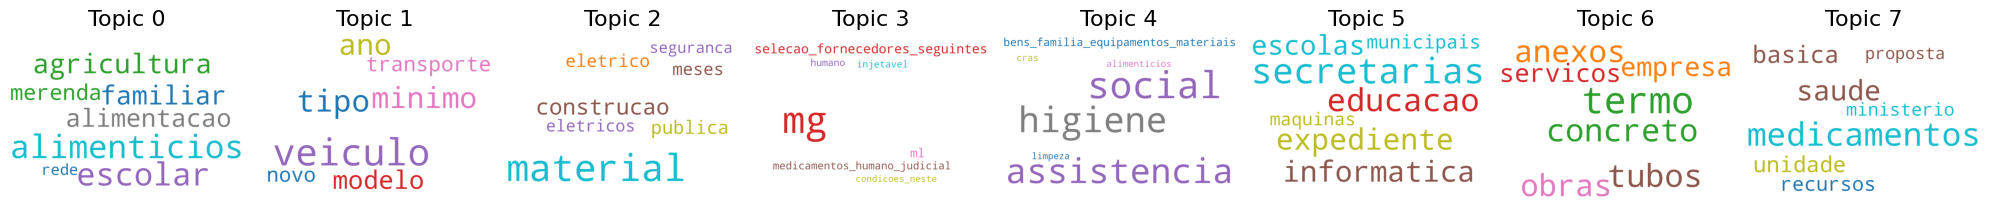

<AxesSubplot: title={'center': 'Topic 7'}>

In [41]:
word_cloud(stop_pt, model, 8)

<p align="justify">A distribuição de palavras chave de cada tópico indica que o modelo conseguiu separar razoavelmente bem os tópicos, apesar de algumas palavras sem tanta relação com as outras, como por exemplo 'cras' no tópico 4.

<b>Os tópicos 3 e 7 serão unidos em um só topico chamado saúde, já que o tópico 7 carrega palavras como 'medicamentos', 'saude' e 'unidade' (de unidade de saúde possivelmente) e o tópico 3 possui palavras chave como 'mg', 'ml' (dosagens de remédios) e 'injetavel'</b>.

<i>A distribuição final dos tópicos está presente na seção 4.5</i> </p>

#### 4.2.3. **Uso do modelo para definir qual licitação pertence a qual tópico**

<p align="justify">Os resultados do modelo, além de retornarem as palavras chave de cada tópico (conforme word cloud), também retornam a probabilidade de cada linha pertencer a cada tópico, o que nesse caso significa, a probabilidade de cada licitação pertencer a cada grupo.</p>

In [42]:
# Recupera os resultados do modelo (probabilidades) e guarda em results
to_pro = [t for t in model[corpus]]
results = pd.DataFrame(to_pro)

# Renomeia a coluna em results para proba
results = results.drop(columns=[1,2])
results.columns = ['proba']
results['proba'] = results['proba'].astype(str)

# Substitui os caracteres como [] e () para depois fazer o split e separa a probabilidade e o número do tópico
results['topics_proba'] = results['proba'].apply(lambda x: x.strip('[]').strip('()').replace('), (', ',').split(','))
df_topics = pd.DataFrame(results['topics_proba'].tolist()).fillna('')

# Inverte as colunas uma a uma, para usarmos .max() e obter a maior probabilidade do texto pertencer ao tópico
df_topics[0] = df_topics[1] + ',' + df_topics[0]
df_topics[1] = df_topics[3] + ',' + df_topics[2]
df_topics[2] = df_topics[5] + ',' + df_topics[4]
df_topics[3] = df_topics[7] + ',' + df_topics[6]
df_topics[4] = df_topics[9] + ',' + df_topics[8]
df_topics[5] = df_topics[11] + ',' + df_topics[10]
df_topics[6] = df_topics[13] + ',' + df_topics[12]
df_topics[7] = df_topics[15] + ',' + df_topics[14]

df_topics = df_topics.drop(columns=[8,9,10,11,12,13,14,15])

df_topics[0] = df_topics[0].apply(lambda x: x.strip().split(','))
df_topics[1] = df_topics[1].apply(lambda x: x.strip().split(','))
df_topics[2] = df_topics[2].apply(lambda x: x.strip().split(','))
df_topics[3] = df_topics[3].apply(lambda x: x.strip().split(','))
df_topics[4] = df_topics[4].apply(lambda x: x.strip().split(','))
df_topics[5] = df_topics[5].apply(lambda x: x.strip().split(','))
df_topics[6] = df_topics[6].apply(lambda x: x.strip().split(','))
df_topics[7] = df_topics[7].apply(lambda x: x.strip().split(','))

# Obtem a maior probabilidade do texto pertencer ao tópico
topicos = df_topics.max(axis=1)
topicos = pd.DataFrame(topicos)

# Renomeia as colunas 
topic_proba = pd.DataFrame(topicos[0].apply(lambda x: x[0])).rename(columns={0 : 'topic_proba'})
topic_num = pd.DataFrame(topicos[0].apply(lambda x: x[1])).rename(columns={0 : 'topic_num'})

# Concatena de volta a df_lic
df_lic = pd.concat([topic_proba, topic_num, df_lic], axis=1)

<p align="justify"> Somente as licitações que têm mais que 50% de probabilidade de pertencer ao tópico serão mantidas, para termos dados da melhor qualidade possível para a análise. O que é <b>90,34%</b> das licitações totais:</p>

In [43]:
df_lic['topic_proba'] = df_lic['topic_proba'].astype(float)
df_lic = df_lic[df_lic['topic_proba']>=0.50] # somente probabilidades maiores que 50% de pertencer ao tópico

<p align="justify"> Criando uma nova variável, chamada <b>topic_name</b>, para denotar o nome real do tópico. Ainda, algumas palavras chave não foram captadas pelo modelo, assim foram corrigidas manualmente. Se a licitação contém aquela palavra será denotada ao grupo:

- 'veiculo' se tem a palavra 'combustíveis' (e suas variações)
- 'escritorio' se tem a palvras 'informática' ou 'expediente' (e não conter a palvra 'escola' ao mesmo tempo)
- 'obras_manutencao' se tem a palavra 'concreto' </p>

In [44]:
df_lic['topic_num'] = df_lic['topic_num'].astype('int64')
df_lic['topic_name'] = df_lic['topic_num'].apply(lambda x: 'alimenticio'                 if x==0           else
                                                           'veiculo'                     if x==1           else  
                                                           'outros'                      if x==2           else
                                                           'saude'                       if (x==3 or x==7) else
                                                           'escritorio'                  if x==4           else
                                                           'obras_manutencao' if x==6           else                                                         
                                                           'escolas_ensino')

df_lic['topic_name'] = df_lic.apply(lambda x: 'veiculo'    if 'combustiveis' in x['ds_objeto_nlp']  else
                                              'veiculo'    if 'combustivel'  in x['ds_objeto_nlp']  else 
                                              'veiculo'    if 'combustíveis' in x['ds_objeto_nlp']  else 
                                              'veiculo'    if 'combustível'  in x['ds_objeto_nlp']  else
                                              'escritorio' if 'informática'  in x['ds_objeto_nlp']  else
                                              'escritorio' if 'expediente'   in x['ds_objeto_nlp']  and 'escola' not in x['ds_objeto_nlp'] else
                                              'obras_manutencao'  if 'concreto' in x['ds_objeto_nlp'] else x['topic_name'], axis=1)                                    

## 4.3. **Modelagem para Polícia Civil e Brigada Militar**

<p align="justify"> Como há somente pouco mais de 100 linhas de dados para esses órgãos fica difícil pro modelo identificar esses tópicos corretamente. E como é basicamente tudo armamento/munição nesse grupo é possível atribuir manualmente o topic_name.</p>

In [45]:
df_pol['topic_name'] = df_pol.apply(lambda x: 'saude'     if 'bisturis'                 in x['ds_objeto_nlp']  else
                                              'saude'     if 'hbm'                      in x['ds_objeto_nlp']  else
                                              'saude'     if 'hospital brigada militar' in x['ds_objeto_nlp']  else
                                              'saude'     if 'cirúrgicos'               in x['ds_objeto_nlp']  else
                                              'veiculo'   if 'viatura'                  in x['ds_objeto_nlp']  else 'armamento', axis=1)                                             

## 4.4. **Unir os dados df_lic e df_pol**

In [46]:
df_pol['topic_proba'] = 1.00 # adicionando a coluna topic_proba com probabilidade 1 para df_pol, já que foi feito manualmente
df_lic = df_lic.drop('topic_num', axis=1) # removendo topic_num, já que não é mais necessária

# Reorganizando as colunas
df_lic = df_lic[['id', 'cd_orgao', 'nm_orgao', 'nr_licitacao', 'ano_licitacao',
                 'cd_tipo_modalidade', 'ds_objeto', 'dt_homologacao', 'vl_homologado',
                 'tp_orgao', 'dt_homologacao_mes', 'dt_homologacao_semana_do_ano',
                 'ds_objeto_nlp', 'topic_name', 'topic_proba']]

<p align="justify"> Agora é possível concatenar os dataframes em um novo, nomeado df_eda, que será usado para a Análise Exploratória de Dados:</p>

In [47]:
df_eda = pd.concat([df_lic, df_pol], axis=0).reset_index(drop=True) # resetando novamente o index, já que df_lic e df_pol foram unidos

## 4.5. **Distribuição final dos tópicos**

| **Nome do Tópico** | **Número do Tópico** | **Descrição Geral** |**Nome no df** |
|:------------------:|:--------------------:|-------------------|:-------------------:|
| Gêneros Alimentícios                 |0                      |  Comida em geral, incluindo alimentação escolar.                  | alimenticio
|  Veículos                             |        1              | Veículos (carros e caminhões), combustível, peças de carro.                      |veiculo
|  Saúde                                | 3 e 7                     | Medicamentos, equipamentos de hospital, seringas, etc                    | saude
|  Escritório                           |  4                    | Materiais do dia a dia do expediente: papel, material de limpeza, cartucho de impressora, computadores, etc                   | escritorio
|  Obras/Manutenção        |   5                   | Obras em geral e  construções; serviços de manutenção e reparo                    | obras_manutencao
|  Escolas/Ensino                   |   6                   |  Material escolar, equipamentos para escola, brinquedos para educação infantil, etc                | escolas_ensino
|  Outros/Random                   |   2                   |  Compras que o modelo não conseguiu captar bem, no caso mistura 'elétrico' com 'segurança pública'| outros
|  Armamento/Munição                   |   (feito manualmente - não está no modelo LDA)                   | Armas e munição                    | escolas_ensino


In [48]:
data_shape(df_eda)

Número de Linhas: 74463
Número de Colunas: 15


# 5. **Exploratory Data Analysis (EDA) e Conclusões**

<p align="justify">Para a análise, os valores de licitações com vl_homologado igual a ZERO serão removidos, pois parecem ser licitações que não foram aprovadas, e portanto não foram efetivamente realizadas.</p>

In [49]:
df_eda = df_eda[df_eda['vl_homologado']!=0]
df_eda.sample(5)

,id,cd_orgao,nm_orgao,nr_licitacao,ano_licitacao,cd_tipo_modalidade,ds_objeto,dt_homologacao,vl_homologado,tp_orgao,dt_homologacao_mes,dt_homologacao_semana_do_ano,ds_objeto_nlp,topic_name,topic_proba
35490,82400222019PRD,82400,PM DE VALE REAL,22,2019,PRD,Aquisição de presentes para distribuição para ...,2019-11-04,NaN,prefeitura,11,45,presentes distribuição crianças evento vale.,escritorio,0.99
17736,624001942017PRE,62400,PM DE URUGUAIANA,194,2017,PRE,Aquisição de bobinas para relógio ponto,2017-12-11,10020.00,prefeitura,12,50,bobinas relógio ponto,obras_manutencao,0.97
46253,4050032017CNV,40500,PM DE ALPESTRE,3,2017,CNV,AQUISIÇÃO DE DOSES DE SÊMEN BOVINO PARA INSEMI...,2017-07-27,23619.00,prefeitura,7,30,doses sêmen bovino inseminação artificial.,saude,0.97
55238,5440090582016PRE,54400,PM DE PELOTAS,9058,2016,PRE,Aquisição de material de limpeza I,2016-08-13,96765.00,prefeitura,8,32,material,outros,0.94
39385,80400162019TMP,80400,PM DE SANTO EXPEDITO DO SUL,16,2019,TMP,Aquisição de Veículo novo para o Gabinete.,2019-07-23,NaN,prefeitura,7,30,veículo gabinete.,veiculo,0.97


## 5.1. **Análise Geral**

#### A análise geral é feita em cima de todos os tipos de órgaos públicos. Será respondida as seguinte pergunta: 

- ### **Quais são os principais bens materiais comprados pelos órgãos públicos do Rio Grande do Sul?**

A partir da visualização dos seguintes gráficos:
  -  Valor Total Homologado das Licitações por Grupo
  -  Quantidade de Licitações por Grupo
  -  Valor Total Homologado das Licitações por Trimestre
  -  Quantidade de Licitações por Trimestre

### Valor Total Homologado das Licitações por Grupo

<AxesSubplot: title={'center': 'Valor Total Homologado das Licitações por Grupo'}>

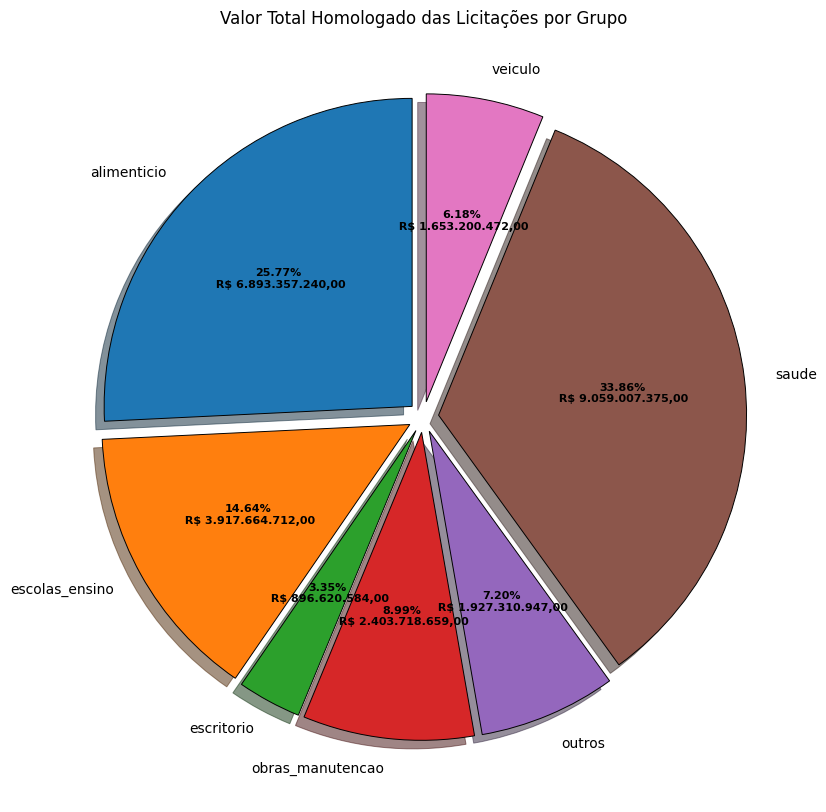

In [50]:
aux = df_eda[['vl_homologado', 'topic_name']].groupby('topic_name').sum().reset_index().rename(columns={'vl_homologado' : 'vl_total_homologado_licitacoes'})
aux = aux[aux['topic_name']!='armamento'] # armamento removido, pois representa menos de 1%, não sendo visível no gráfico
pie_chart(aux=aux, y='vl_total_homologado_licitacoes', titulo='Valor Total Homologado das Licitações por Grupo', labels=aux['topic_name'].to_list())

### Quantidade de Licitações por Grupo

<AxesSubplot: xlabel='topic_name', ylabel='qtd_licitacoes'>

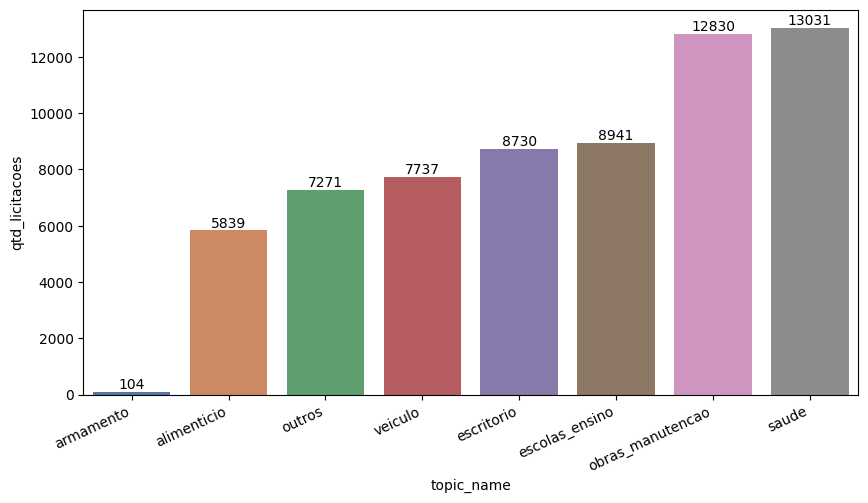

In [51]:
aux = df_eda[['topic_name', 'id']].groupby('topic_name').count().reset_index().rename(columns={'id' : 'qtd_licitacoes'})
bar_plot_values_on_top(x='topic_name', y='qtd_licitacoes', aux=aux.sort_values(by='qtd_licitacoes'), rotate=True)

### Valor Total Homologado das Licitações por Trimestre

<AxesSubplot: title={'center': 'Valor Total Homologado das Licitações por Trimestre (Todos os Setores)'}>

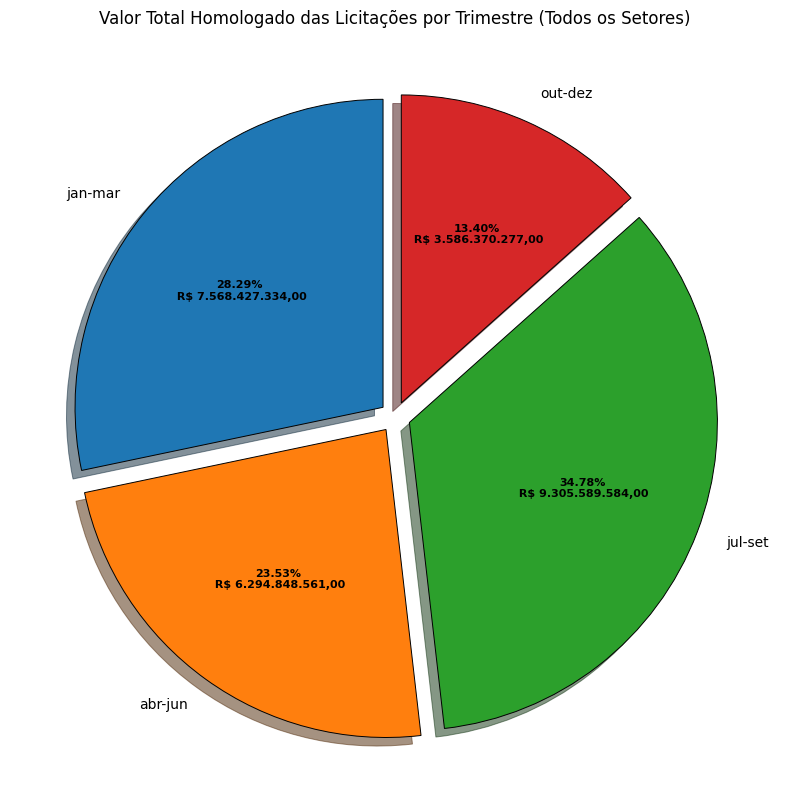

In [52]:
aux = df_eda[['vl_homologado', 'dt_homologacao_mes']].groupby('dt_homologacao_mes').sum().reset_index().rename(columns={'vl_homologado' : 'vl_total_homologado_licitacoes'})

# Valor por trimestre
aux2 = pd.DataFrame()
aux2['vl_homologado_trimestre'] = aux['vl_total_homologado_licitacoes'].groupby(aux['vl_total_homologado_licitacoes'].index // 3).sum()
aux2['trimestre'] = ['jan-mar', 'abr-jun', 'jul-set', 'out-dez']

pie_chart(aux=aux2, y='vl_homologado_trimestre', titulo='Valor Total Homologado das Licitações por Trimestre (Todos os Setores)', labels=aux2['trimestre'].to_list())

### Quantidade de Licitações por Trimestre

<AxesSubplot: xlabel='trimestre', ylabel='qtd_licitacoes_trimestre'>

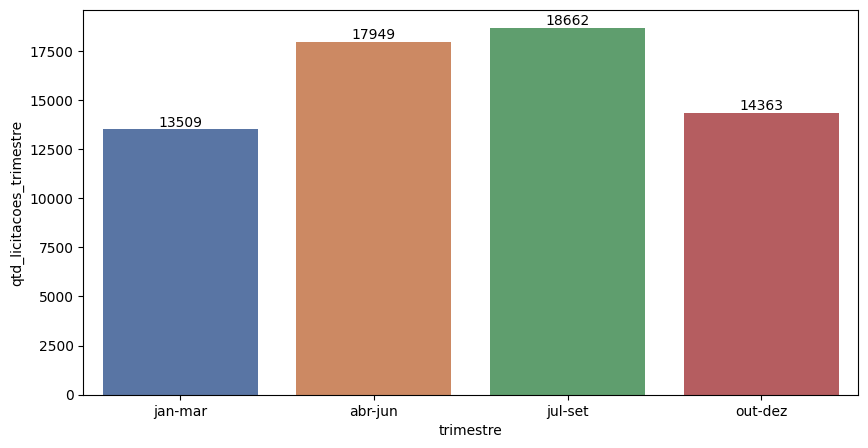

In [53]:
aux = df_eda[['id', 'dt_homologacao_mes']].groupby('dt_homologacao_mes').count().reset_index().rename(columns={'id' : 'qtd_licitacoes'})

# Valor por trimestre
aux2 = pd.DataFrame()
aux2['qtd_licitacoes_trimestre'] = aux['qtd_licitacoes'].groupby(aux['qtd_licitacoes'].index // 3).sum()
aux2['trimestre'] = ['jan-mar', 'abr-jun', 'jul-set', 'out-dez']

bar_plot_values_on_top(x='trimestre', y='qtd_licitacoes_trimestre', aux=aux2)

Portanto, 

- ### **Quais são os principais bens materiais comprados pelos órgãos públicos do Rio Grande do Sul?**

- <h3 align="justify"> Se observarmos o valor total homologado das licitações de 2016 a 2019, o setor que cobre o maior gasto é saúde, com R$ 9 bilhões de reais no período, o que representa 1/3 dos gastos. Em segundo e terceiros lugares estão o gasto com alimentação (lembrando que inclui alimentação escolar) e educação. </h3>
  
- <h3 align="justify"> Um fato interessante a se observar é o gasto com Obras/Construção/Manutenção, pois tem o segundo maior número de licitações, estando muito próximo da Saúde, que novamente é o primeiro. Porém Obras/Construção/Manutenção quando olhado para os valores gastos, este é apenas o quarto maior gasto (9% do total), muito atrás de Escolas, Alimentação e Saúde. Uma possível explicação é devido às manutenções, que devem ter o valor médio de cada licitação baixo, pois são serviços de reparo em geral, o que não costumam custar muito, entretanto são serviços mais frequentes, levando a um grande de solicitações de manutenção, e, portanto muitas licitações em Obras/Construção/Manutenção.</h3>

- <h3 align="justify"> Quando analisamos as licitações por trimestre claramente o último trimestre é o que menos tem valor gasto e o segundo com menos quantidade de licitações, o que faz sentido intuitivamente. Porém, o primeiro trimestre é aquele com a menor quantidade de licitações, mas o segundo com maior valor de licitações. Uma explicação possível é a compra de produtos em grande quantidade que serão usados o ano inteiro. Por exemplo, computadores novos para uma escola municipal, alimentos não perecíveis para merenda, reparos em geral nos órgãos públicos. </h3>

## 5.2. **Análise Específica (Criação e Validação das Hipóteses)**

##### Com essa análise será possível responder a pergunta:

- #### É possível identificar algum padrão nas compras? Seja por época do ano ou por tipo de órgão comprador? O que mais é possível descobrir sobre as licitações do estado?

*Na Análise Específica serão apontadas as Descobertas, como Descoberta 1, Descoberta 2 ... Descoberta n, para facilitar a organização.*

### As hipóteses serão divididas em três tipos: 
#### 1) Hipóteses por número de licitações: Total de 8 Hipóteses
#### 2) Hipóteses por valor de licitações: Total de 5 Hipóteses
#### 3) Hipóteses por época do ano: Total de 4 Hipóteses

**Cada hipótese com um resultado interessante terá um comentário e conclusão acerca do assunto.**

### 1) Hipóteses por número de licitações:

- #### **H1:**  Mais de 40% das licitações de Prefeituras são do grupo 'escolas_ensino' + 'alimenticio'
- #### **H2:** O grupo menos recorrente nas licitações das Câmaras Municipais é 'alimenticio'
- #### **H3:** Mais de 90% das licitações da Polícia/Brigada são do grupo 'armamento'
- #### **H4:** O grupo 'saude' é um dos três mais recorrentes nas licitações de Bancos
- #### **H5:** Menos de 10% das licitações de Insituições de Previdência/Assistência Social são do grupo 'alimenticio' + 'veiculos'
- #### **H6:** Mais da metade das licitações de Empresas de Energia são do grupo 'obras_manutencao'
- #### **H7:** Mais da metade das licitações de Empresas de Transporte são do grupo 'veiculo'
- #### **H8:** O grupo mais recorrente nas licitações para as universidades é 'escolas'

### **H1:** Mais de 40% das licitações de Prefeituras são do grupo 'escolas_ensino' + 'alimenticio'

**FALSO**: 26% das licitações de Prefeituras são do grupo 'escolas_ensino' + 'alimenticio'.

<AxesSubplot: xlabel='topic_name', ylabel='qtd_licitacoes'>

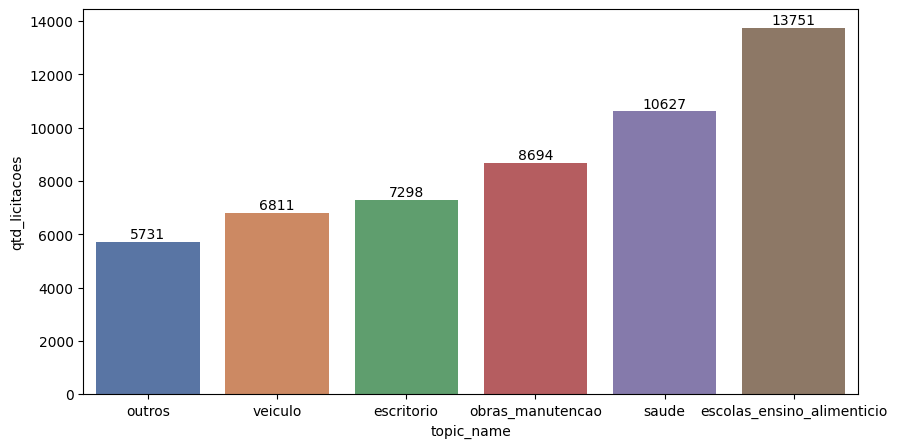

In [54]:
# Seleciona so orgãos=prefeitura
aux = df_eda[df_eda['tp_orgao']=='prefeitura'][['id', 'topic_name']].groupby('topic_name').count().reset_index()

# Seleciona só escolas_ensino + alimenticio
escolas_ensino_alimenticio = ['alimenticio', 'escolas_ensino']
aux2 = pd.DataFrame(aux[aux['topic_name'].isin(escolas_ensino_alimenticio)].sum()).T
aux2 = aux2.set_axis(['escolas_ensino_alimenticio'], axis='rows').drop('topic_name', axis=1)
aux2 = aux2.reset_index().rename(columns={'index' : 'topic_name'})

# Concatena de volta
aux = pd.concat([aux, aux2])
aux = aux[(aux['topic_name']!='alimenticio') & (aux['topic_name']!='escolas_ensino')].rename(columns={'id' : 'qtd_licitacoes'}) # remove escolas_ensino individuais

# Plot
bar_plot_values_on_top(x='topic_name', y='qtd_licitacoes', aux=aux.sort_values(by='qtd_licitacoes'))

In [55]:
pct = round((aux.loc[aux['topic_name']=='escolas_ensino_alimenticio', 'qtd_licitacoes'].values[0]/aux['qtd_licitacoes'].sum())*100, 2)
print(f'{pct}% das licitações de Prefeituras são do grupo escolas_ensino + alimenticio.')

25.99% das licitações de Prefeituras são do grupo escolas_ensino + alimenticio.


### **H2:** O grupo menos recorrente nas licitações das Câmaras Municipais é 'alimenticio'

**VERDADEIRO**: O grupo menos recorrente nas licitações das Câmaras Municipais é 'alimenticio'.

<AxesSubplot: xlabel='topic_name', ylabel='qtd_licitacoes'>

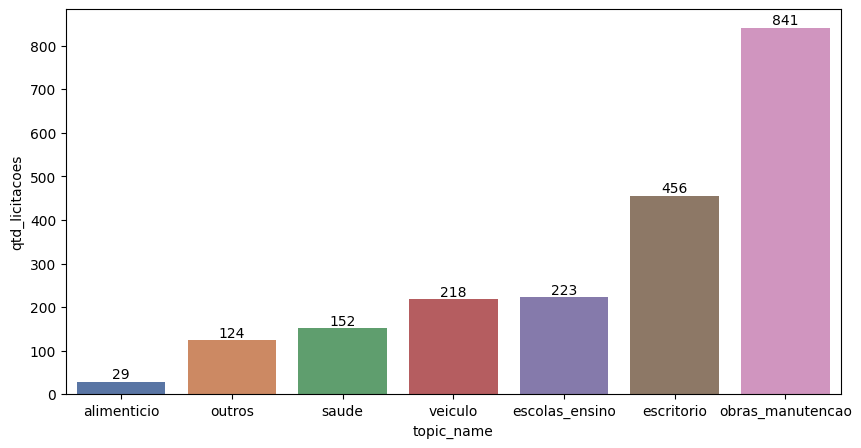

In [56]:
aux = df_eda[df_eda['tp_orgao']=='camara'][['id', 'topic_name']].groupby('topic_name').count().reset_index().rename(columns={'id' : 'qtd_licitacoes'})
bar_plot_values_on_top(x='topic_name', y='qtd_licitacoes', aux=aux.sort_values(by='qtd_licitacoes'))

### **H3:** Mais de 90% das licitações da Polícia/Brigada são do grupo 'armamento'

**FALSO**: 75% das licitações da Polícia/Brigada são do grupo armamento.

<AxesSubplot: xlabel='topic_name', ylabel='qtd_licitacoes'>

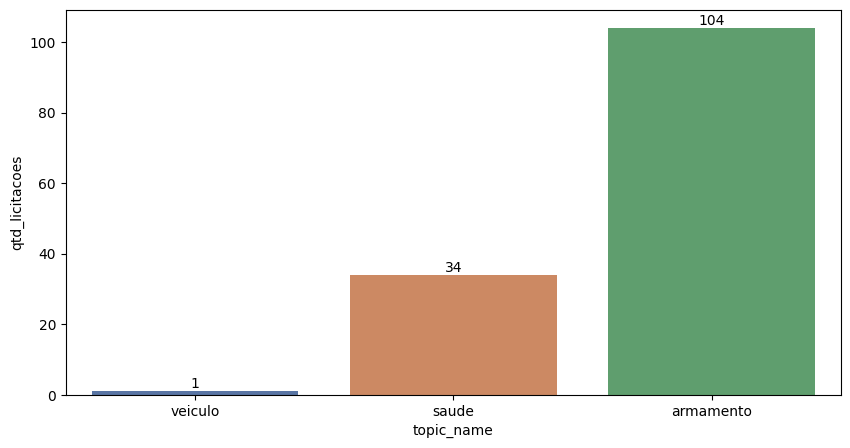

In [57]:
aux = df_eda[df_eda['tp_orgao']=='policia'][['id', 'topic_name']].groupby('topic_name').count().reset_index().rename(columns={'id' : 'qtd_licitacoes'})
bar_plot_values_on_top(x='topic_name', y='qtd_licitacoes', aux=aux.sort_values(by='qtd_licitacoes'))

In [58]:
pct = round((aux.loc[aux['topic_name']=='armamento', 'qtd_licitacoes'].values[0]/aux['qtd_licitacoes'].sum())*100, 2)
print(f'{pct}% das licitações da Polícia/Brigada são do grupo armamento.')

74.82% das licitações da Polícia/Brigada são do grupo armamento.


### **H4:** O grupo 'saude' é um dos três mais recorrentes nas licitações de Bancos

**VERDADEIRO**: O grupo 'saude' é o segundo mais recorrente nas licitações de Bancos (provavelmente porque o Banrisul tem o próprio plano de sáude, no caso a Cabergs).

<AxesSubplot: xlabel='topic_name', ylabel='qtd_licitacoes'>

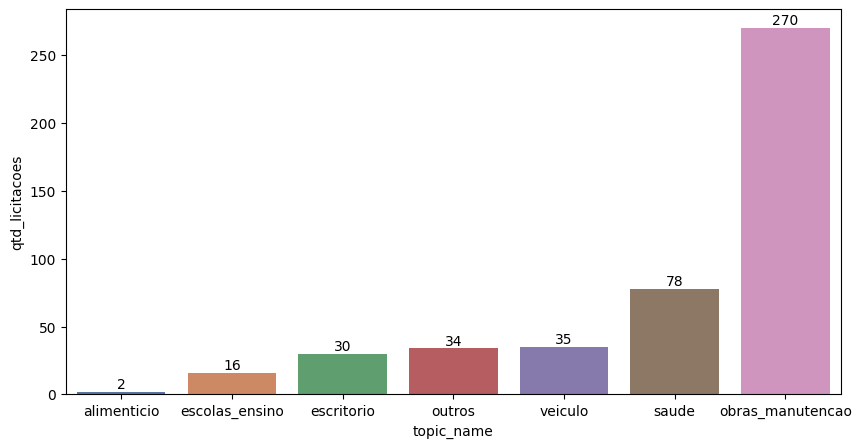

In [59]:
aux = df_eda[df_eda['tp_orgao']=='banco'][['id', 'topic_name']].groupby('topic_name').count().reset_index().rename(columns={'id' : 'qtd_licitacoes'})
bar_plot_values_on_top(x='topic_name', y='qtd_licitacoes', aux=aux.sort_values(by='qtd_licitacoes'))

### **H5:** Menos de 10% das licitações de Insituições de Previdência/Assistência Social são do grupo 'alimenticio' + 'veiculos'

**VERDADEIRO**: Somente 5% das licitações de Insituições de Previdência/Assistência Social são do grupo 'alimenticio' + 'veiculos'

<AxesSubplot: xlabel='topic_name', ylabel='qtd_licitacoes'>

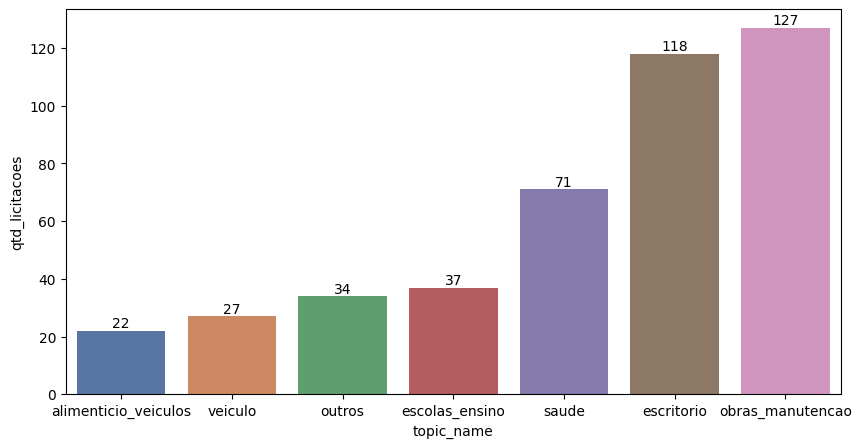

In [60]:
# Seleciona so orgãos=prev
aux = df_eda[df_eda['tp_orgao']=='prev'][['id', 'topic_name']].groupby('topic_name').count().reset_index()

# Seleciona só alimenticio + veiculos
alimenticio_veiculos = ['alimenticio', 'veiculos']
aux2 = pd.DataFrame(aux[aux['topic_name'].isin(alimenticio_veiculos)].sum()).T
aux2 = aux2.set_axis(['alimenticio_veiculos'], axis='rows').drop('topic_name', axis=1)
aux2 = aux2.reset_index().rename(columns={'index' : 'topic_name'})

# Concatena de volta
aux = pd.concat([aux, aux2])
aux = aux[(aux['topic_name']!='alimenticio') & (aux['topic_name']!='veiculos')].rename(columns={'id' : 'qtd_licitacoes'}) # remove alimenticio + veiculos individuais

# Plot
bar_plot_values_on_top(x='topic_name', y='qtd_licitacoes', aux=aux.sort_values(by='qtd_licitacoes'))

In [61]:
pct = round((aux.loc[aux['topic_name']=='alimenticio_veiculos', 'qtd_licitacoes'].values[0]/aux['qtd_licitacoes'].sum())*100, 2)
print(f'{pct}% das licitações de Insituições de Previdência/Assistência Social são do grupo alimenticio + veiculos.')

5.05% das licitações de Insituições de Previdência/Assistência Social são do grupo alimenticio + veiculos.


### **H6:** Mais da metade das licitações de Empresas de Energia são do grupo 'obras_manutencao'

**VERDADEIRO**: 53%  das licitações de Empresas de Energia são do grupo obras_manutencao.

<AxesSubplot: xlabel='topic_name', ylabel='qtd_licitacoes'>

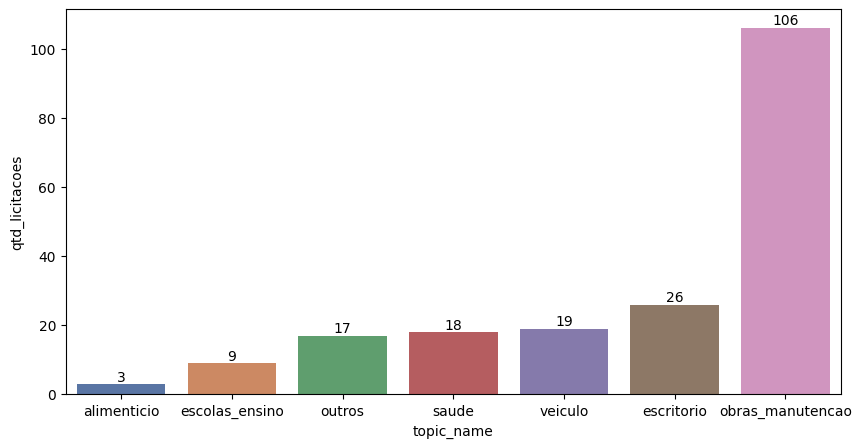

In [62]:
aux = df_eda[df_eda['tp_orgao']=='energia'][['id', 'topic_name']].groupby('topic_name').count().reset_index().rename(columns={'id' : 'qtd_licitacoes'})
bar_plot_values_on_top(x='topic_name', y='qtd_licitacoes', aux=aux.sort_values(by='qtd_licitacoes'))

In [63]:
pct = round((aux.loc[aux['topic_name']=='obras_manutencao', 'qtd_licitacoes'].values[0]/aux['qtd_licitacoes'].sum())*100, 2)
print(f'{pct}%  das licitações de Empresas de Energia são do grupo obras_manutencao.')

53.54%  das licitações de Empresas de Energia são do grupo obras_manutencao.


### **H7:** Mais da metade das licitações de Empresas de Transporte são do grupo 'veiculo'

**FALSO**: 23% das licitações de Empresas de Transporte são do grupo 'veiculo'.

<AxesSubplot: xlabel='topic_name', ylabel='qtd_licitacoes'>

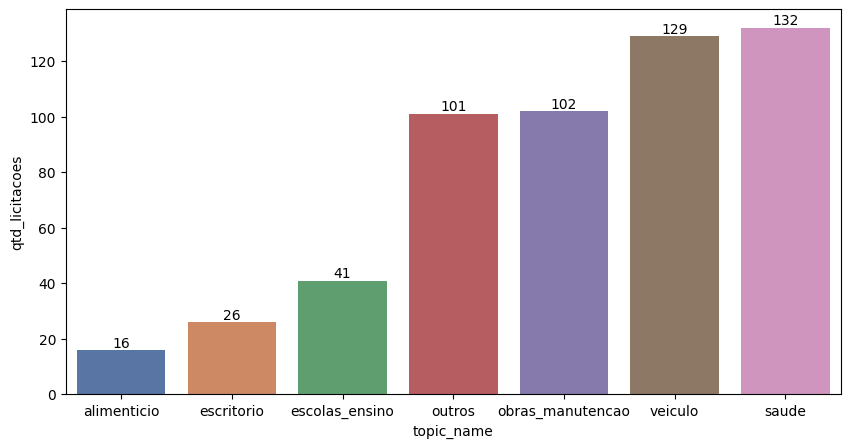

In [64]:
aux = df_eda[df_eda['tp_orgao']=='transporte'][['id', 'topic_name']].groupby('topic_name').count().reset_index().rename(columns={'id' : 'qtd_licitacoes'})
bar_plot_values_on_top(x='topic_name', y='qtd_licitacoes', aux=aux.sort_values(by='qtd_licitacoes'))

In [65]:
pct = round((aux.loc[aux['topic_name']=='veiculo', 'qtd_licitacoes'].values[0]/aux['qtd_licitacoes'].sum())*100, 2)
print(f'{pct}% das licitações de Empresas de Transporte são do grupo veiculo.')

23.58% das licitações de Empresas de Transporte são do grupo veiculo.


- <h3 align="justify"> <b>Descoberta 1</b>: Esse resultado vai ao encontro com a segunda resposta da Análise Geral, pois o gasto com veículos por Empresas de Transporte acaba sendo um pouco ofuscado por 'obras_manutencao', provavelmente na manutenção da frota. Além do grupo 'saude', pois as empresas de ônibus devem ter o próprio órgão de planos de saúde, dado o tamanho das empresas.</h3>

### **H8:** O grupo mais recorrente nas licitações para as universidades é 'escolas'

**FALSO**: O grupo 'escolas' é o segundo mais recorrente nas licitações para as universidades, sendo 'obras_manutencao' é o mais recorrente.

<AxesSubplot: xlabel='topic_name', ylabel='qtd_licitacoes'>

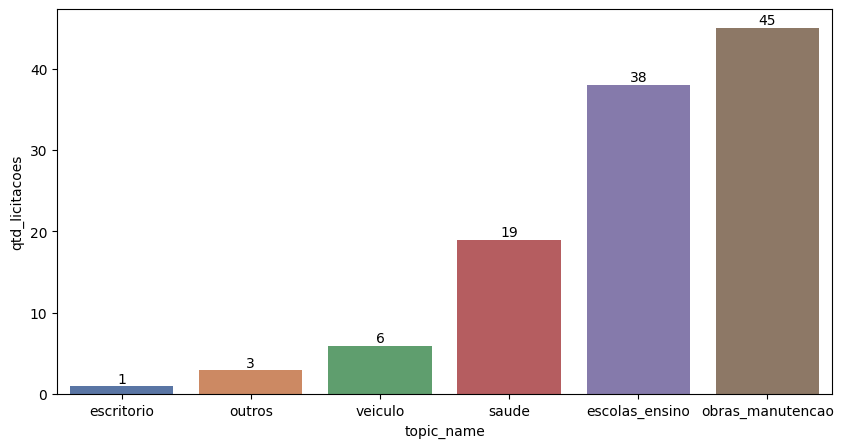

In [66]:
aux = df_eda[df_eda['tp_orgao']=='universidade'][['id', 'topic_name']].groupby('topic_name').count().reset_index().rename(columns={'id' : 'qtd_licitacoes'})
bar_plot_values_on_top(x='topic_name', y='qtd_licitacoes', aux=aux.sort_values(by='qtd_licitacoes'))

- <h3 align="justify"> <b>Descoberta 2</b>: Esse resultado se deve provavelmente ao grupo 'obras_manutencao'. Exemplos de possíveis atividades nesse sentido: Conserto de ar-condicionado; manutenção de cadeiras, projetor, computadores, etc; obras em prédios e no entorno do campus (o que é recorrente na UFRGS).</h3>

### 2) Hipóteses por valor de licitações:

- #### **H9:** Mais de 85% do gasto total de Hospitais/Insituições de Saúde é com 'saúde'
- #### **H10:** Mais de 75% do gasto total de empresas de saneamento são com 'servicos' e 'obras'
- #### **H11:** Os dois maiores gastos de Consórcios Intermunicipais são do grupo 'saude' e 'obras_manutencao'
- #### **H12:** O valor mediano gasto com 'veiculo' é mais de duas vezes maior que o valor mediano gasto com 'escritorio', para licitações de Órgãos Principais.
- #### **H13:** O valor mediano gasto com sáude é maior que o valor mediano gasto com escolas, para Insituições de Previdência/Assistência Social

### **H9:** Mais de 85% do gasto total de Hospitais/Insituições de Saúde é com 'saúde'

**VERDADEIRO**: 90% do gasto total de Hospitais/Insituições de Saúde é com saúde.

<AxesSubplot: title={'center': 'Gasto das Licitações de Hospitais/Insituições de Saúde'}>

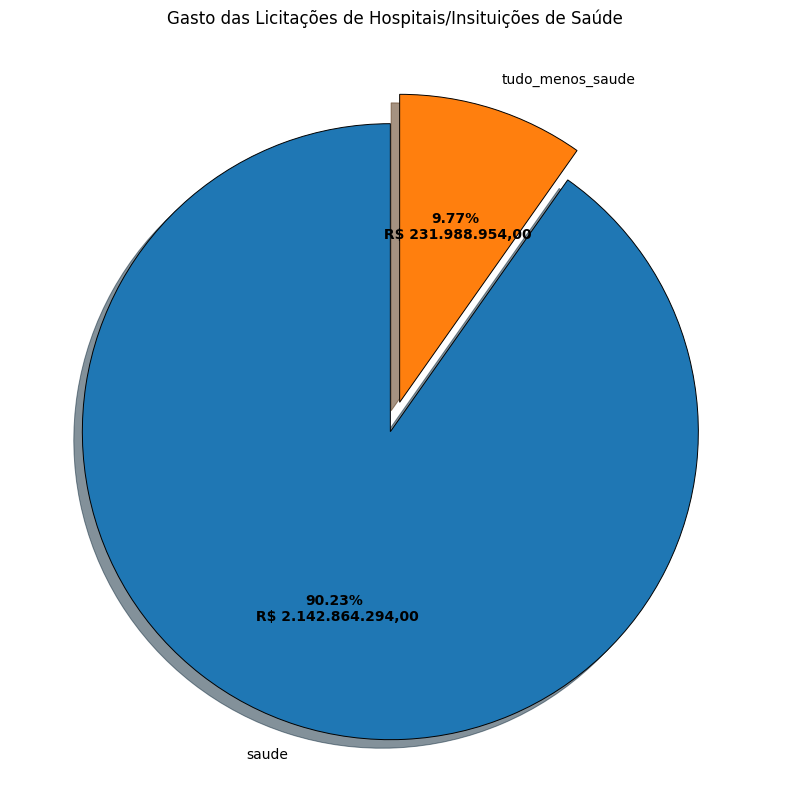

In [67]:
aux = df_eda[df_eda['tp_orgao']=='saude'][['vl_homologado', 'topic_name']].groupby('topic_name').sum().reset_index()

# Seleciona tudo que não for saúde
aux2 = pd.DataFrame(aux[aux['topic_name']!='saude'].sum()).T
aux2 = aux2.set_axis(['tudo_menos_saude'], axis='rows').drop('topic_name', axis=1)
aux2 = aux2.reset_index().rename(columns={'index' : 'topic_name'})

# Concatena de volta
aux = pd.concat([aux, aux2])
aux = aux[aux['topic_name'].str.contains('saude')]

pie_chart(aux=aux, y='vl_homologado', titulo='Gasto das Licitações de Hospitais/Insituições de Saúde', labels=aux['topic_name'].to_list(), size=10)

### **H10:** Mais de 75% do gasto total de Empresas de Água/Esgoto são com 'obras_manutencao'

**FALSO**: 62% do gasto total de Empresas de Água/Esgoto são com 'obras_manutencao

<AxesSubplot: title={'center': 'Gasto das Licitações de Empresas de Água/Esgoto'}>

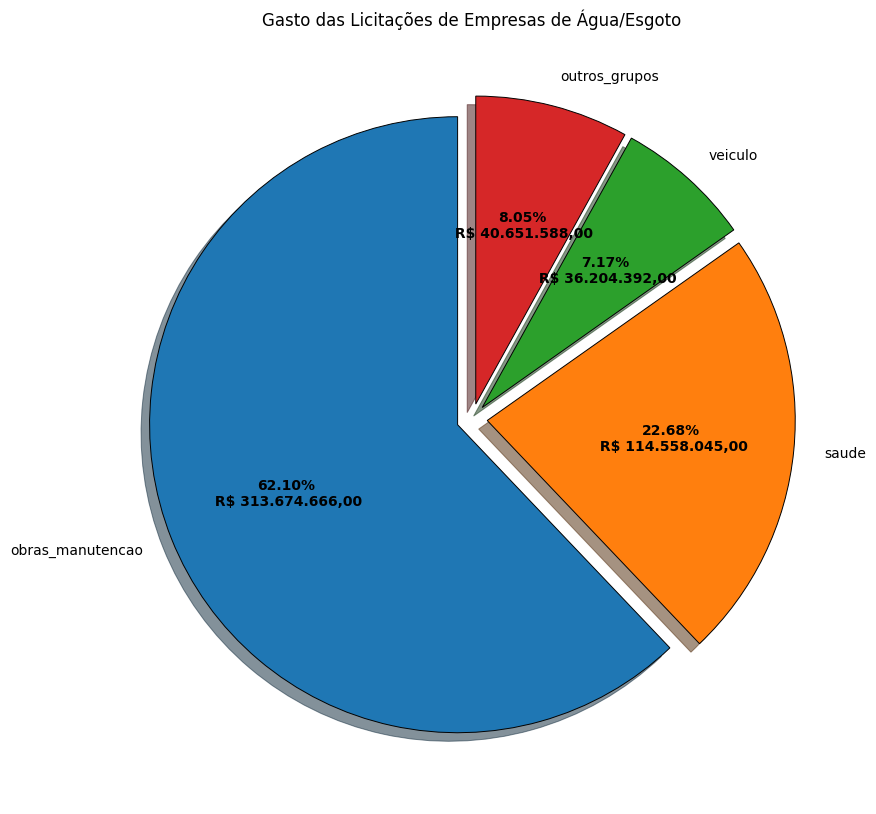

In [68]:
# Para faciliar a visualização os 3 grupos com maior % serão separados, pois os outros grupos serão unidos num grupo só
aux = df_eda[df_eda['tp_orgao']=='agua_esgoto'][['vl_homologado', 'topic_name']].groupby('topic_name').sum().reset_index()
top_grupos = aux.sort_values(by='vl_homologado', ascending=False)['topic_name'].to_list()[0:3] # 3 grupos com maior % no gasto

# Seleciona tudo que não for top_grupos
aux2 = pd.DataFrame(aux[~aux['topic_name'].isin(top_grupos)].sum()).T
aux2 = aux2.set_axis(['outros_grupos'], axis='rows').drop('topic_name', axis=1)
aux2 = aux2.reset_index().rename(columns={'index' : 'topic_name'})

# Concatena de volta
aux = pd.concat([aux, aux2])
top_grupos.append('outros_grupos') # junta o novo item (outros_grupos em top_grupos)
aux = aux[aux['topic_name'].isin(top_grupos)] # seleção final

pie_chart(aux=aux, y='vl_homologado', titulo='Gasto das Licitações de Empresas de Água/Esgoto', labels=aux['topic_name'].to_list(), size=10)

### **H11:** Os dois maiores gastos de Consórcios Intermunicipais são do grupo 'saude' e 'obras_manutencao'

**FALSO**: Os dois maiores gastos de Consórcios Intermunicipais são do grupo 'saude' e 'escolas_ensino'

<AxesSubplot: title={'center': 'Gasto de Consórcios Intermunicipais'}>

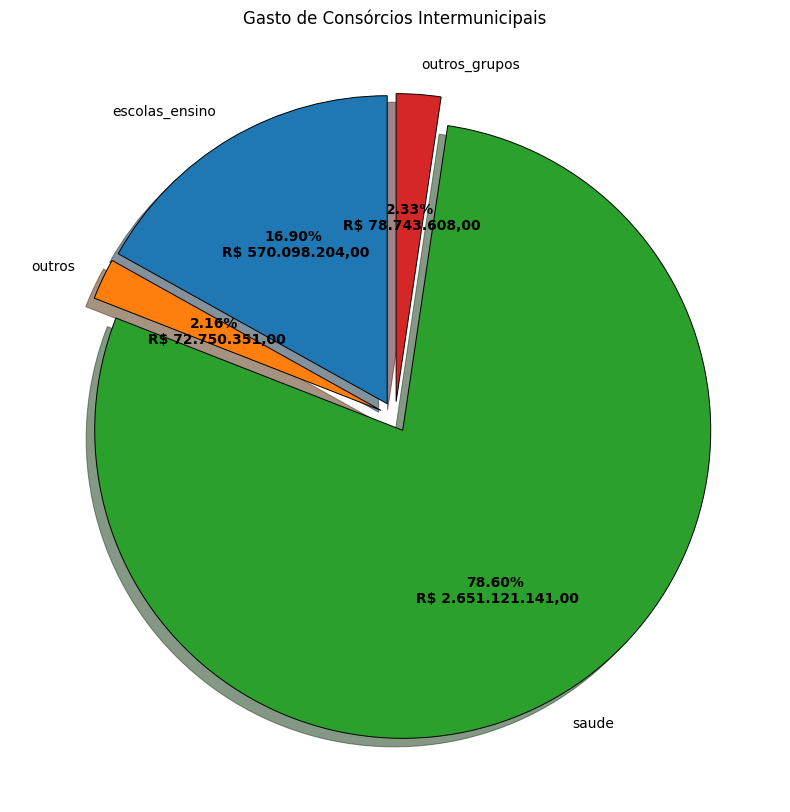

In [69]:
# Para faciliar a visualização os 3 grupos com maior % serão separados, pois os outros grupos serão unidos num grupo só
aux = df_eda[df_eda['tp_orgao']=='cons_interm'][['vl_homologado', 'topic_name']].groupby('topic_name').sum().reset_index()
top_grupos = aux.sort_values(by='vl_homologado', ascending=False)['topic_name'].to_list()[0:3] # 3 grupos com maior % no gasto

# Seleciona tudo que não for top_grupos
aux2 = pd.DataFrame(aux[~aux['topic_name'].isin(top_grupos)].sum()).T
aux2 = aux2.set_axis(['outros_grupos'], axis='rows').drop('topic_name', axis=1)
aux2 = aux2.reset_index().rename(columns={'index' : 'topic_name'})

# Concatena de volta
aux = pd.concat([aux, aux2])
top_grupos.append('outros_grupos') # junta o novo item (outros_grupos em top_grupos)
aux = aux[aux['topic_name'].isin(top_grupos)] # seleção final

pie_chart(aux=aux, y='vl_homologado', titulo='Gasto de Consórcios Intermunicipais', labels=aux['topic_name'].to_list(), size=10)

- <h3 align="justify"> <b>Descoberta 3</b>: O fato de 'obras_manutencao' não ser nem o quarto maior gasto aqui é totalmente inesperado. Para uma possível explicação seria necessário olhar mais a fundo o papel de um Consórcio Intermunicipal. </h3>

### **H12:** O valor mediano gasto com 'veiculo' é mais de duas vezes maior que o valor mediano gasto com 'escritorio', para licitações de Órgãos Principais (Secretarias do Estado, Tribunais, Assembléia, etc).

**VERDADEIRO**: O valor mediano gasto com 'veiculo' é mais de duas vezes maior que o valor mediano gasto com 'escritorio', para licitações de Órgãos Principais.

<AxesSubplot: xlabel='topic_name', ylabel='vl_homologado_mediano'>

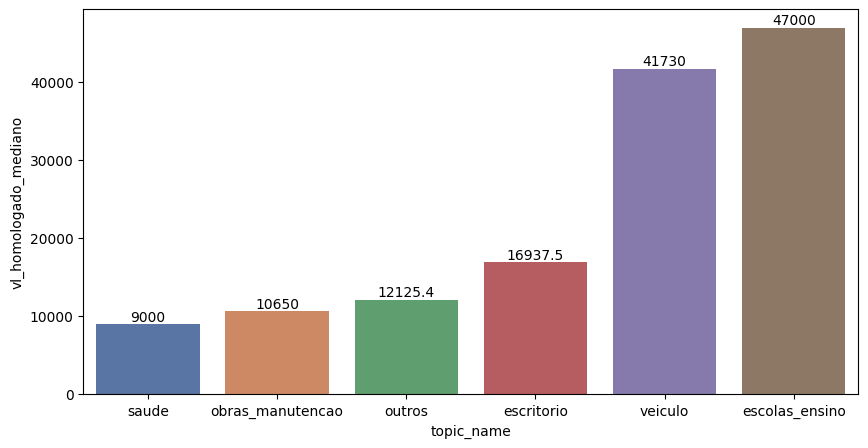

In [70]:
aux = df_eda[df_eda['tp_orgao']=='orgaos_principais'][['vl_homologado', 'topic_name']].groupby('topic_name').median().reset_index().rename(columns={'vl_homologado' : 'vl_homologado_mediano'})
aux = aux[aux['topic_name']!='alimenticio'] # removendo 'alimenticio' aqui pois só tem uma observação
bar_plot_values_on_top(x='topic_name', y='vl_homologado_mediano', aux=aux.sort_values(by='vl_homologado_mediano'))

- <h3 align="justify"> <b>Descoberta 4</b>: Esse resultado talvez signifique que para os Órgãos Principais (Secretarias do Estado, Tribunais, Assembléia, etc) o gasto com a categoria 'veiculo' não seja muito em combustíveis, mas sim principalmente com automóveis mesmo. </h3>

### **H13:** O valor mediano gasto com sáude é maior que o valor mediano gasto com escolas, para Insituições de Previdência/Assistência Social

**FALSO**: O valor mediano gasto com sáude menor que o valor mediano gasto com escolas, para licitações de Previdência/Ass.Social

<AxesSubplot: xlabel='topic_name', ylabel='vl_homologado_mediano'>

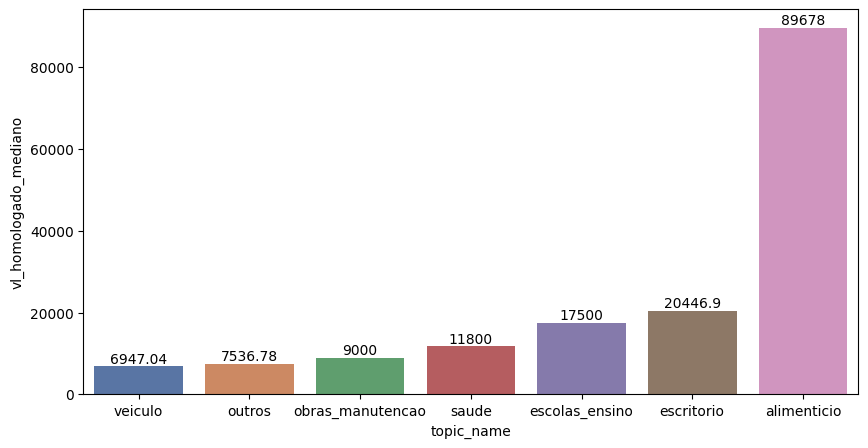

In [71]:
aux = df_eda[df_eda['tp_orgao']=='prev'][['vl_homologado', 'topic_name']].groupby('topic_name').median().reset_index().rename(columns={'vl_homologado' : 'vl_homologado_mediano'})
bar_plot_values_on_top(x='topic_name', y='vl_homologado_mediano', aux=aux.sort_values(by='vl_homologado_mediano'))

- <h3 align="justify"> <b>Descoberta 5</b>: Esse resultado vai ao encontro com a terceira resposta da Análise Geral. O valor mediano do 'alimenticio' é tão alto, pois devem ser compras de produtos não perecíveis em grandes quantidades no começo do ano, sendo consumidos ao longo do ano.</h3>

### 3) Hipóteses por época do ano:

- #### **H14:** No primeiro bimestre do ano as prefeituras gastam mais de 33% daquilo que é destinado a 'escolas_ensino' e 'alimenticio'
- #### **H15:** No primeiro trimestre do ano as empresas de transporte gastam em torno de 50% daquilo que é destinado a 'veiculo'
- #### **H16:** A mediana de gastos das universidades nos bimestres de janeiro-fevereiro e junho-julho é pelo menos 50% maior que mediana de gastos nos outros meses
- #### **H17:** As Insituições de Previdência/Assistência Social tem seu maior gasto médio em dezembro

### **H14:** No primeiro bimestre do ano as prefeituras gastam mais de 33% daquilo que é destinado a 'escolas_ensino' e 'alimenticio'

**FALSO**: O maior gasto com 'escolas_ensino' e 'alimenticio' por parte das prefeituras se dá no bimestre julho-agosto, seguido por março-abril. O bimestre janeiro-fevereiro representa somente 3,62% do total gasto para os anos de 2016-2019.

<AxesSubplot: title={'center': 'Gasto das Licitações de Prefeituras com Educação e Alimentação por Bimestre'}>

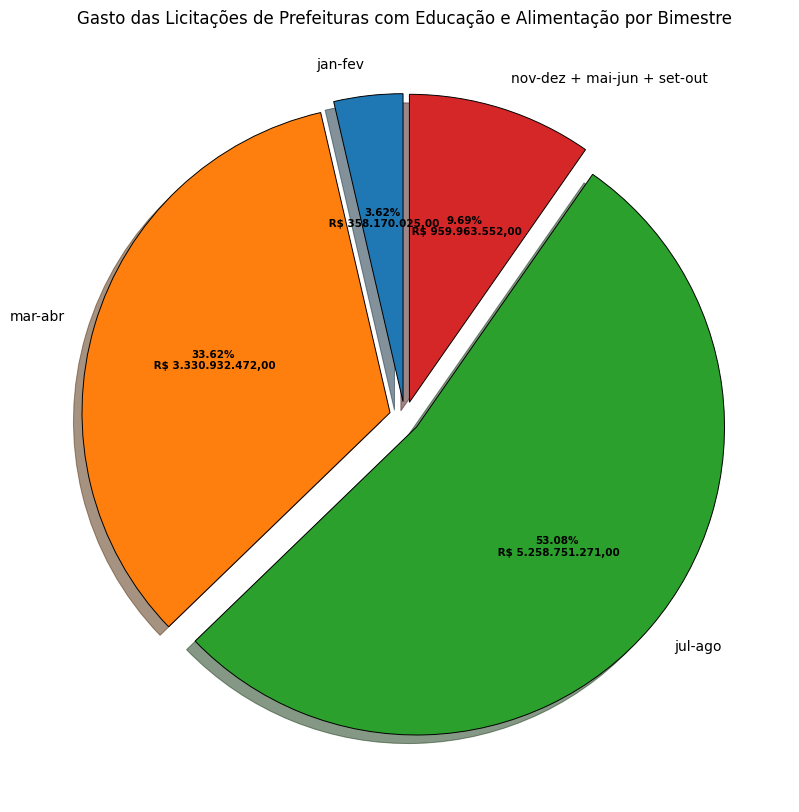

In [72]:
# Gasto com alimentacao e escolas_ensino para todas as prefeituras
aux = df_eda[(df_eda['tp_orgao']=='prefeitura') & (df_eda['topic_name'].isin(['escolas_ensino', 'alimenticio']))][['vl_homologado', 'dt_homologacao_mes']].groupby('dt_homologacao_mes').sum().reset_index()

# Valor por bimestre
aux2 = pd.DataFrame()
aux2['vl_homologado_bimestre'] = aux['vl_homologado'].groupby(aux['vl_homologado'].index // 2).sum()
aux2['bimestre'] = ['jan-fev', 'mar-abr', 'mai-jun', 'jul-ago', 'set-out', 'nov-dez']

# adiciona a soma do valor de nov-dez + mai-jun + set-out no aux
meses = ['nov-dez', 'mai-jun', 'set-out']
aux2.loc[-1] = [aux2.loc[aux2['bimestre'].isin(meses), 'vl_homologado_bimestre'].sum(), 'nov-dez + mai-jun + set-out']

# seleciona só 'nov-dez, mai-jun, set-out'; 'jul-ago'; 'mar-abr'; 'jan-fev'
aux = aux2[aux2['bimestre'].isin(['nov-dez + mai-jun + set-out', 'jul-ago', 'mar-abr', 'jan-fev'])].reset_index()
pie_chart(aux=aux, y='vl_homologado_bimestre', titulo='Gasto das Licitações de Prefeituras com Educação e Alimentação por Bimestre', labels=aux['bimestre'].to_list(), size=7.5)

- <h3 align="justify"> <b>Descoberta 6</b>: Esse resultado é totalmente inesperado. Talvez seja algo a ver com a época do ano em que os produtos comprados sejam mais baratos, mas seria necessário analisar mais a fundo essa questão.</h3>

### **H15:** No primeiro trimestre do ano as empresas de transporte gastam em torno de 50% daquilo que é destinado a 'veiculo'

**FALSO**: É no segundo trimestre do ano as empresas de transporte gastam em torno de 50% daquilo que é destinado a 'veiculo'

<AxesSubplot: title={'center': 'Gasto das Licitações de Empresas de Ônibus com Veículos por Trimestre'}>

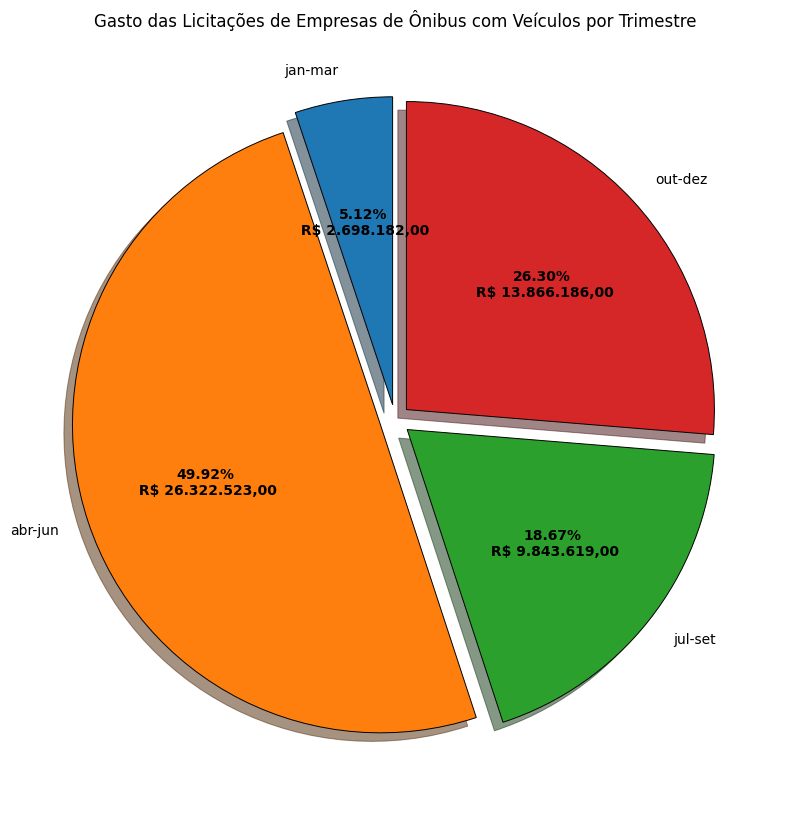

In [73]:
aux = df_eda[(df_eda['tp_orgao']=='transporte') & (df_eda['topic_name'].isin(['veiculo']))][['vl_homologado', 'dt_homologacao_mes']].groupby('dt_homologacao_mes').sum().reset_index()

# Valor por trimestre
aux2 = pd.DataFrame()
aux2['vl_homologado_trimestre'] = aux['vl_homologado'].groupby(aux['vl_homologado'].index // 3).sum()
aux2['trimestre'] = ['jan-mar', 'abr-jun', 'jul-set', 'out-dez']

pie_chart(aux=aux2, y='vl_homologado_trimestre', titulo='Gasto das Licitações de Empresas de Ônibus com Veículos por Trimestre', labels=aux2['trimestre'].to_list(), size=10)

- <h3 align="justify"><b>Descoberta 7</b>: Uma possível explicação para esse resultado é a menor quantidade de passageiros no transporte público nos primeiros meses do ano. Então, quando as pessoas começam a voltar das férias há mais demanda por combustível, compra de novas frotas, etc, por isso quase metade do gasto nesse setor se dá entre abril e junho. </h3>

### **H16:** A mediana de gastos das universidades nos bimestres de janeiro-fevereiro e junho-julho é pelo menos 50% maior que mediana de gastos nos outros meses

**NÃO FOI POSSÍVEL VALIDAR**: Não há nenhuma licitação de Universidades no bimestre de janeiro-fevereiro, ou melhor, os dados para o período não estão disponíveis.

In [74]:
aux = df_eda[(df_eda['tp_orgao']=='universidade')][['vl_homologado', 'dt_homologacao_mes']].groupby('dt_homologacao_mes').median().reset_index()
aux

,dt_homologacao_mes,vl_homologado
0,3,3511.00
1,4,3914.00
2,5,6121.50
3,6,2403.72
4,7,1871.65
5,8,10495.00
6,9,3559.50
7,10,8971.49


### **H17:** As Insituições de Previdência/Assistência Social tem seu maior gasto médio em dezembro

**FALSO**: As Insituições de Previdência/Assistência Social tem seu maior gasto médio em março, seguido por dezembro.

<AxesSubplot: xlabel='dt_homologacao_mes', ylabel='vl_homologado_medio'>

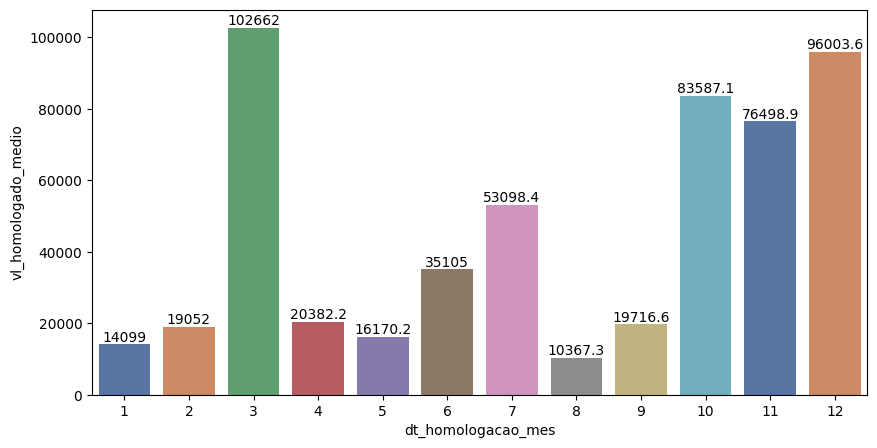

In [75]:
aux = df_eda[df_eda['tp_orgao']=='prev'][['vl_homologado', 'dt_homologacao_mes']].groupby('dt_homologacao_mes').mean().reset_index().rename(columns={'vl_homologado' : 'vl_homologado_medio'})
bar_plot_values_on_top(x='dt_homologacao_mes', y='vl_homologado_medio', aux=aux.sort_values(by='vl_homologado_medio'))

# 6. **Conclusão**

<h3 align="justify">Para esse projeto foram disponibilizados dados de licitações de órgãos públicos do Estado do Rio Grande do Sul, entre os anos 2016 e 2019. Os dados foram concatenados, limpos e novas features foram criadas. A parte textual dos dados (descrição de cada licitação) foi processada usando NLP, para que o algoritmo LDA fosse aplicado, para agrupar os diferentes textos em tópicos similares.</h3>

<h3 align="justify">Isso tudo foi feito para possibilitar a exploração dos dados. <b>17</b> Hipóteses foram criadas e validadas. No fim, as perguntas inicialmente postas foram respondidas, além de <b>7</b> descobertas encontradas.</h3>

### Possíveis melhorias na solução:

- #### Testar redução de dimensionalidade no 'corpus', como UMAP ou t-SNE.
- #### Aprimorar o processamento com NLP, principalmente para o modelo conseguir separar melhor os tópicos. 
- #### Corrigir pela inflação os valores de cada ano.
- #### Mapa interativo (com filtros) que mostre a distribuição dos valores homologados por prefeitura.